the goal is to create a good model to forecast PM2.5 levels in China. We ultimately would like to forecast the number of days that are high for PM2.5 levels averaged over the course of each calendar month for each city. 


1. General Information

Ultimately this is a time-series forecasting project where we are trying to forecast the number of days for which PM2.5 levels are high. The denotation “high” is somewhat arbitrary and is up to you to define. 


The dataset contains five (5) CSVs corresponding to data taken in five cities in China. Each file contains the following information:


No: row number

year: year of data in this row

month: month of data in this row

day: day of data in this row

hour: hour of data in this row

season: season of data in this row

PM: PM2.5 concentration (ug/m^3)

DEWP: Dew Point (Celsius Degree)

TEMP: Temperature (Celsius Degree)

HUMI: Humidity (%)

PRES: Pressure (hPa)

cbwd: Combined wind direction

Iws: Cumulated wind speed (m/s)

precipitation: hourly precipitation (mm)

Iprec: Cumulated precipitation (mm)

In [2]:
%config Completer.use_jedi = False

/home/arashs/anaconda3/envs/MLenv/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.
  """Entry point for launching an IPython kernel.


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display_html
from itertools import chain,cycle
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from datetime import datetime
from chinese_calendar import is_workday, is_holiday


seed = 42
np.random.seed(seed)
plt.style.use('seaborn')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'

# PM2.5 exceedance threshold
Air quality guideline is an annual mean concentration guideline for particulate matter from the World Health Organization, most recently updated in 2005 and published in 2006.[1] The 2005 guidelines offer guidance about four air pollutants: particulate matter (PM), ozone (O3), nitrogen dioxide (NO2) and sulfur dioxide (SO2). **The guideline stipulates that PM2.5 not exceed 10 μg/m3 annual mean, or 25 μg/m3 24-hour mean**.

Due to the severe impacts of the problem several of the haze episodes recorded in China attracted a large attention from worldwide researchers (Huang et al., 2014, Zhao et al., 2011, Wang et al., 2005, Wang et al., 2013). Some studies report average daily values higher than 1000 μg m−3 of PM2.5 (Wang et al., 2005) while the World Health Organization suggests a daily limit of 25 μg m−3 and an annual limit of 10 μg m−3 to mitigate its impacts on human health (WHO, 2005). Besides this limits, WHO defined three interim targets. **The Chinese government adopted the mildest, the interim target 1 (IT1). In this case an annual limit of 35 μg m−3 of PM2.5 and a daily limit of 75 μg m−3 of PM2.5 was established.** Nonetheless, these limits, defined to the IT1, corresponds to the highest mean concentrations reported in studies of long-term health effects, and may reflect higher but unknown historical concentrations that may have contributed to the observed health effects (WHO, 2005). According to the WHO (2005) in developed world the IT1 has been shown to be associated with significant mortality.

# Loading data

In [4]:
file_names = os.listdir('./data/FiveCitiesPMData')
file_names

['GuangzhouPM20100101_20151231.csv',
 'ChengduPM20100101_20151231.csv',
 'ShenyangPM20100101_20151231.csv',
 'ShanghaiPM20100101_20151231.csv',
 'BeijingPM20100101_20151231.csv',
 '.ipynb_checkpoints']

In [5]:
file_names = [file_name for file_name in file_names if '.csv' in file_name]
cities = [file_name.split('PM')[0] for file_name in file_names]
cities

['Guangzhou', 'Chengdu', 'Shenyang', 'Shanghai', 'Beijing']

In [6]:
dic_df_cities = {}
for file_name in file_names:
    city = file_name.split('PM')[0]
    df_ = pd.read_csv('./data/FiveCitiesPMData/' + file_name)
    df_.set_index(pd.to_datetime(df_[['year','month','day','hour']]),inplace=True)
    df_.drop(['No','year','month','day','hour','season'],axis=1,inplace=True)
    df_['cbwd'].replace('cv',pd.NA,inplace=True)
    #df_.replace({'NE':np.pi/4,'SE':3*(np.pi/4),'SW':-3*(np.pi/4),'NW':-np.pi/4},inplace=True) ## Converting wind direction to degree
    dic_df_cities[city] = df_

## Missing value treatment

## PM2.5 measurements:

To treat the missing data with minimum loss of information, we first downsample the data into daily bins and find the maximum value in each bin. The followig figure depicts the days with at least one reported measurement at one of stations in green and days without any reported measurements in red:

In [7]:
def beautify_axis(ax,left_space = 0.01,bottom_space=0.01):
    ax.spines['left'].set_position(('axes', -left_space))
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position(('axes', -bottom_space))
    ax.spines['top'].set_color('none')
    
    ax.spines['left'].set_bounds(ax.get_ybound())
    ax.spines['bottom'].set_bounds(ax.get_xbound())
    
    ax.tick_params(direction='in',length=3,width=1)
    pass
    

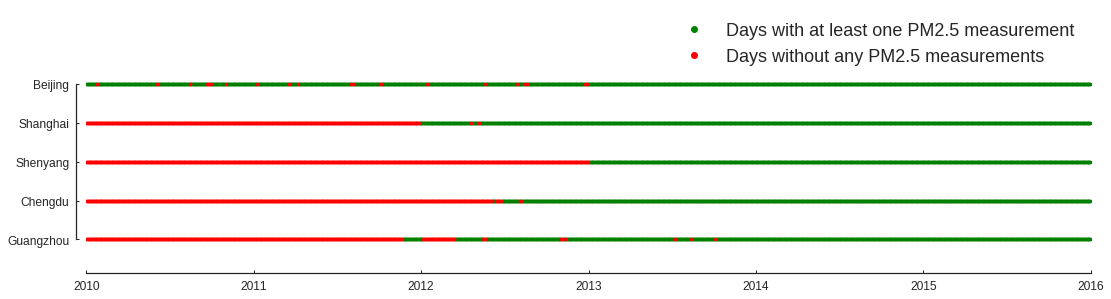

In [7]:
plt.style.use('seaborn-white')
fig,ax = plt.subplots(1,1,figsize=(18,5))
label_non_missing = 'Days with at least one PM2.5 measurement'
label_missing = 'Days without any PM2.5 measurements'
for i,city in enumerate(dic_df_cities.keys()):
    df_city = dic_df_cities[city]
    PM_cols = df_city.columns[df_city.columns.str.contains('PM')]
    df_city_daily_max = df_city[PM_cols].max(axis=1).resample('D').max()
    dates_at_least_one_measure = df_city_daily_max[df_city_daily_max.notnull()].index
    dates_no_measure = df_city_daily_max[df_city_daily_max.isnull()].index
    ax.plot(dates_at_least_one_measure,i*np.ones(dates_at_least_one_measure.shape[0]),
            linestyle='None',
            marker='.',
            color='green',
            label = label_non_missing)
    ax.plot(dates_no_measure,i*np.ones(dates_no_measure.shape[0]),
            linestyle='None',
            marker='.',
            color='red',
            label = label_missing)
    label_non_missing = None
    label_missing = None

ax.legend(loc=0,fontsize=18,ncol=1,markerscale=2,fancybox=True)
ax.set_xlim((df_city_daily_max.index[0],pd.to_datetime('2016-1-1')))
ax.set_ylim((-1.0,6.0))
ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(cities)
beautify_axis(ax,bottom_space=-0.02)
ax.spines['left'].set_bounds((0,4))
plt.show()

Next, we count the **number of contiguous days with missing values** in each city before imputating the missing values:

In [8]:
def display_side_by_side(list_dfs,titles=cycle([''])):
    html_str=''
    for df,title in zip(list_dfs, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [8]:
list_n_cont_miss = []
for city in cities:
    df_city = dic_df_cities[city]
    PM_cols = df_city.columns[df_city.columns.str.contains('PM')]
    series_daily_max = df_city[PM_cols].max(axis=1).resample('D').max()
    mask = series_daily_max.isna()
    d = series_daily_max.index.to_series()[mask].groupby((~mask).cumsum()[mask]).agg(['first','last', 'size'])
    d.rename(columns=dict(size='num of contig null', first='Start_Date',last='End_date')).reset_index(drop=True)
    list_n_cont_miss.append(d)

display_side_by_side(list_n_cont_miss,titles=cycle(cities))   

Guangzhou 
 
 
 
 first 
 last 
 size 
 
 
 
 
 0 
 2010-01-01 
 2011-11-20 
 689 
 
 
 45 
 2012-01-05 
 2012-03-14 
 70 
 
 
 107 
 2012-05-16 
 2012-05-21 
 6 
 
 
 270 
 2012-11-01 
 2012-11-05 
 5 
 
 
 276 
 2012-11-12 
 2012-11-12 
 1 
 
 
 511 
 2013-07-06 
 2013-07-07 
 2 
 
 
 546 
 2013-08-12 
 2013-08-12 
 1 
 
 
 597 
 2013-10-03 
 2013-10-03 
 1 
 
 
 Chengdu 
 
 
 
 first 
 last 
 size 
 
 
 
 
 0 
 2010-01-01 
 2012-05-13 
 864 
 
 
 1 
 2012-05-15 
 2012-06-03 
 20 
 
 
 9 
 2012-06-12 
 2012-06-23 
 12 
 
 
 50 
 2012-08-04 
 2012-08-06 
 3 
 
 
 Shenyang 
 
 
 
 first 
 last 
 size 
 
 
 
 
 0 
 2010-01-01 
 2012-12-31 
 1096 
 
 
 Shanghai 
 
 
 
 first 
 last 
 size 
 
 
 
 
 0 
 2010-01-01 
 2011-12-27 
 726 
 
 
 112 
 2012-04-18 
 2012-04-19 
 2 
 
 
 127 
 2012-05-05 
 2012-05-07 
 3 
 
 
 Beijing 
 
 
 
 first 
 last 
 size 
 
 
 
 
 23 
 2010-01-24 
 2010-01-25 
 2 
 
 
 153 
 2010-06-05 
 2010-06-06 
 2 
 
 
 221 
 2010-08-14 
 2010-08-15 
 2 
 
 
 258 
 2010-09-22 
 2010-09-26 
 5 
 
 
 259 
 2010-09-28 
 2010-09-29 
 2 
 
 
 292 
 2010-11-02 
 2010-11-02 
 1 
 
 
 359 
 2011-01-09 
 2011-01-09 
 1 
 
 
 426 
 2011-03-18 
 2011-03-20 
 3 
 
 
 443 
 2011-04-07 
 2011-04-07 
 1 
 
 
 558 
 2011-08-01 
 2011-08-02 
 2 
 
 
 562 
 2011-08-07 
 2011-08-07 
 1 
 
 
 619 
 2011-10-04 
 2011-10-06 
 3 
 
 
 719 
 2012-01-15 
 2012-01-16 
 2 
 
 
 843 
 2012-05-20 
 2012-05-20 
 1 
 
 
 912 
 2012-07-29 
 2012-07-29 
 1 
 
 
 925 
 2012-08-12 
 2012-08-12 
 1 
 
 
 931 
 2012-08-19 
 2012-08-20 
 2 
 
 
 1056 
 2012-12-24 
 2012-12-27 
 4

In [9]:
truncate_date = {'Guangzhou':'2012-03-15',
                 'Chengdu':'2012-06-04',
                 'Shenyang':'2013-1-1',
                 'Shanghai':'2011-12-28',
                 'Beijing':'2010-1-1'
                 }

In [10]:
for city in dic_df_cities.keys():
    dic_df_cities[city] = dic_df_cities[city][truncate_date[city]:]

In [ ]:
list_n_cont_miss = []
for city in cities:
    df_city = dic_df_cities[city]
    PM_cols = df_city.columns[df_city.columns.str.contains('PM')]
    series_daily_max = df_city[PM_cols].max(axis=1).resample('D').max()
    mask = series_daily_max.isna()
    d = series_daily_max.index.to_series()[mask].groupby((~mask).cumsum()[mask]).agg(['first','last', 'size'])
    d.rename(columns=dict(size='num of contig null', first='Start_Date',last='End_date')).reset_index(drop=True)
    list_n_cont_miss.append(d)

display_side_by_side(list_n_cont_miss,titles=cycle(cities))   

## Outlier treatment

### Visual inspection of outliers

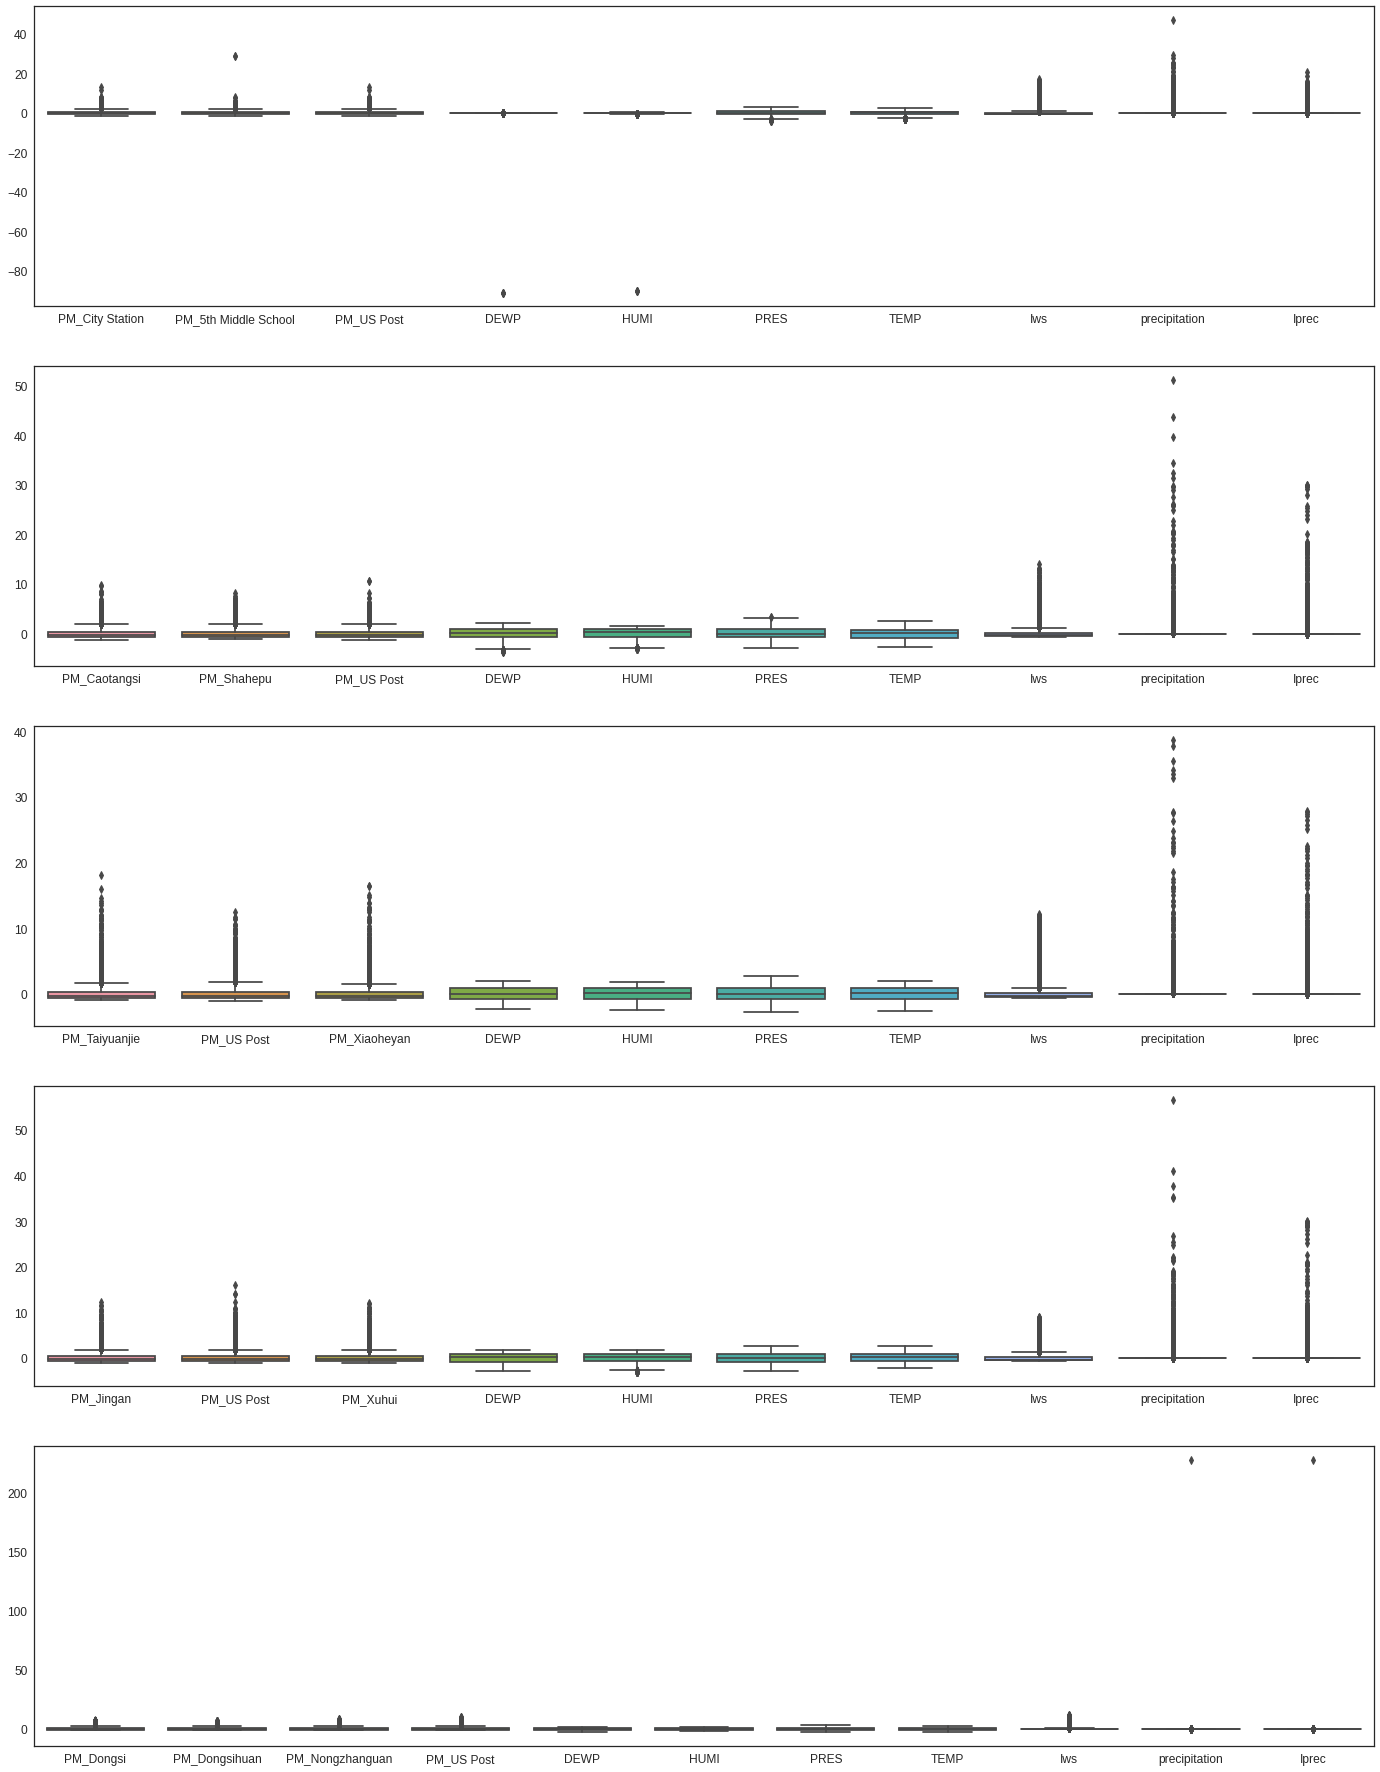

In [12]:
fig,axes = plt.subplots(5,1,figsize=(24,32))
for i,city in enumerate(dic_df_cities.keys()):
    ax = axes[i]
    df_city = dic_df_cities[city].copy().drop('cbwd',axis=1)
    scaler = StandardScaler()
    X_city_std = scaler.fit_transform(df_city)
    df_city_std = pd.DataFrame(columns=df_city.columns,index=df_city.index,data=X_city_std)
    sns.boxplot(data=df_city_std,ax=ax)
    

### Outlier removal
**We assume that values with Z-score>3 in each column are due to observation error and replace them with NaN:**

In [11]:
for city in ['Beijing','Guangzhou', 'Chengdu', 'Shenyang', 'Shanghai']:
    df_ = dic_df_cities[city].copy()
    features_cols = df_.drop('cbwd',axis=1)
    for col in features_cols:
        idx_outliers = df_[np.abs(df_[col]-df_[col].mean()) > (3*df_[col].std())].index
        df_.loc[idx_outliers,col] = np.nan
    dic_df_cities[city] = df_

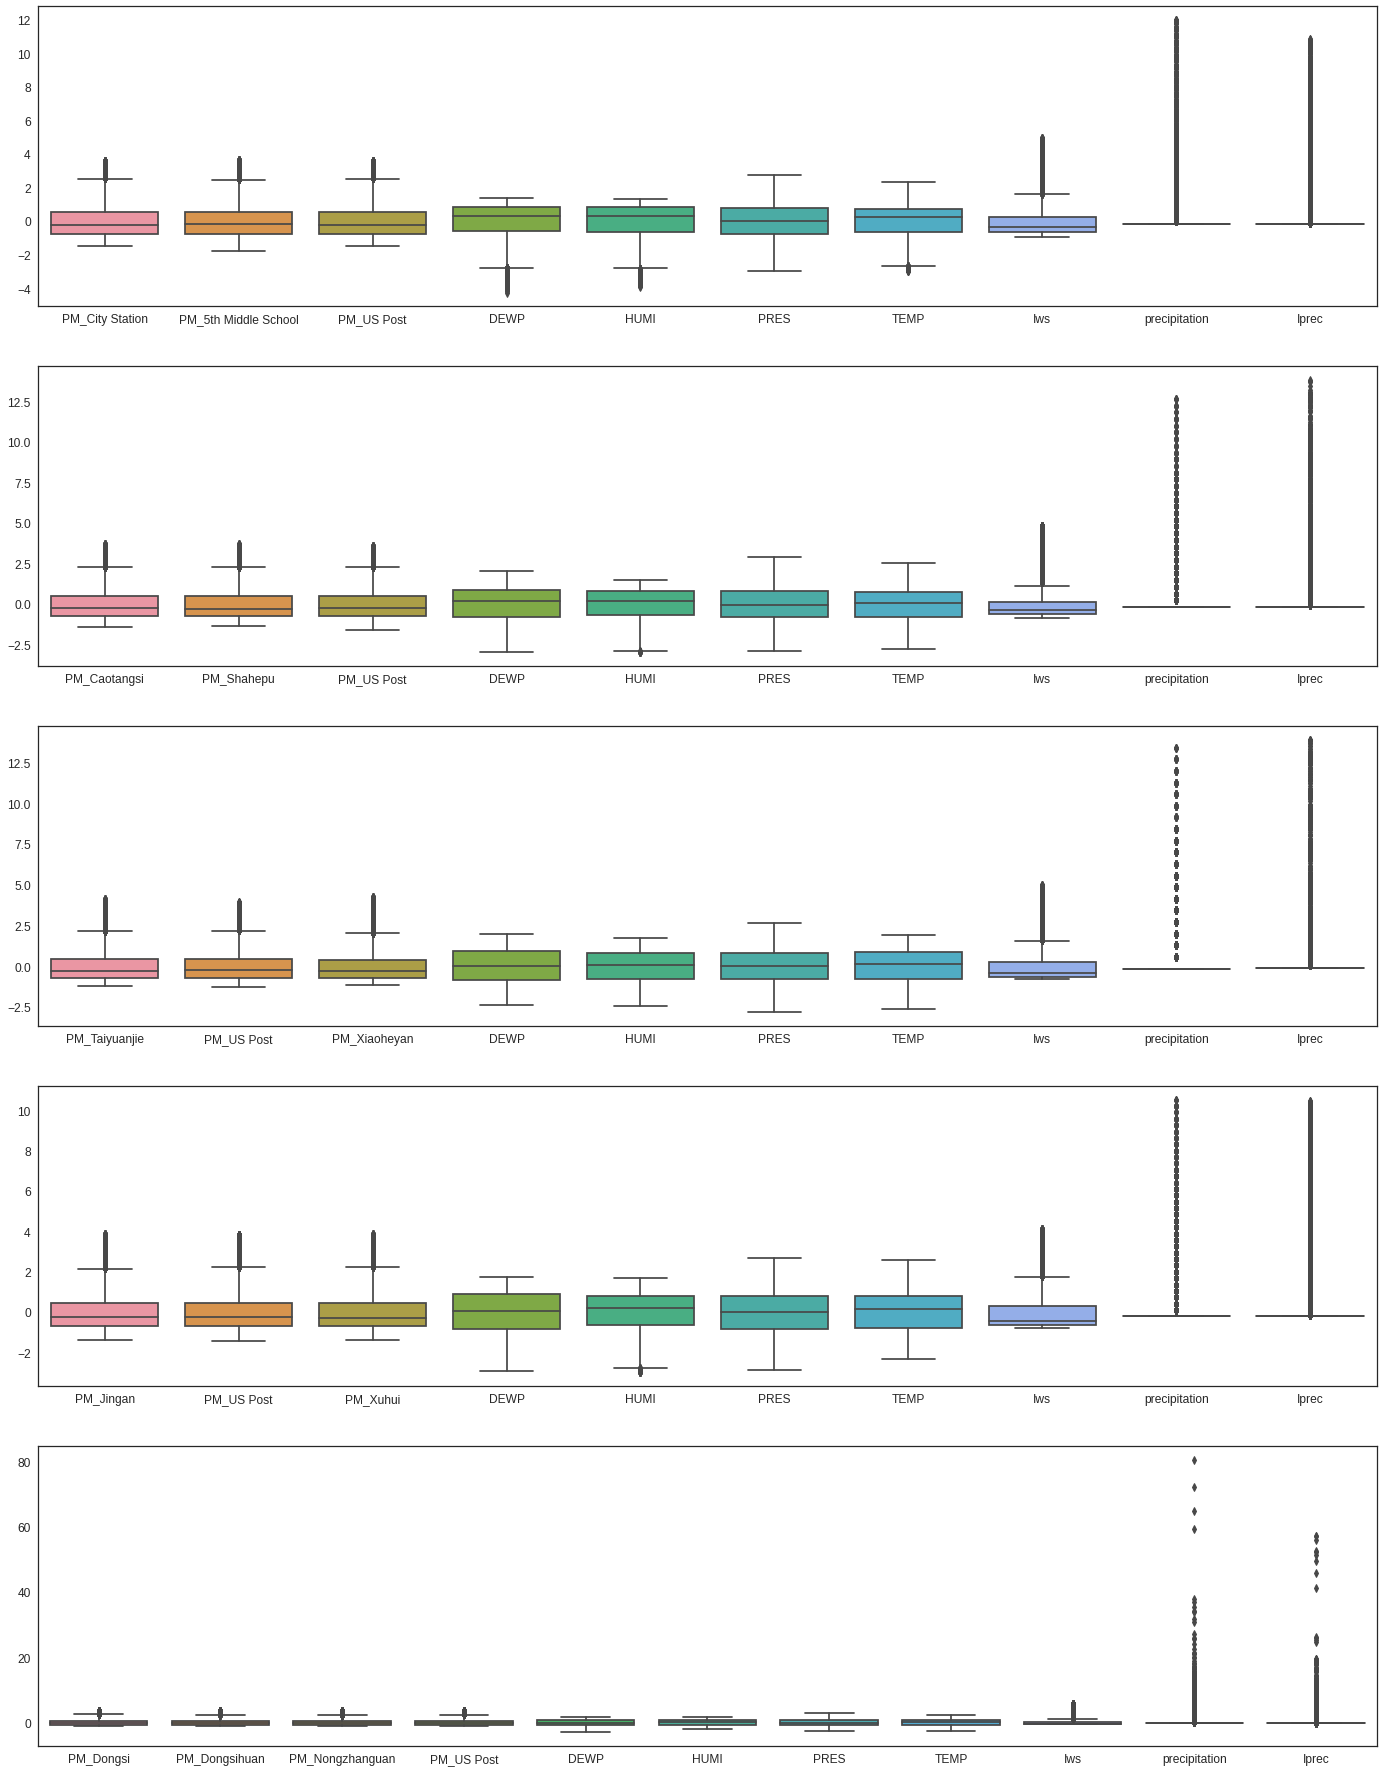

In [14]:
fig,axes = plt.subplots(5,1,figsize=(24,32))
for i,city in enumerate(dic_df_cities.keys()):
    ax = axes[i]
    df_city = dic_df_cities[city].copy().drop('cbwd',axis=1)
    scaler = StandardScaler()
    X_city_std = scaler.fit_transform(df_city)
    df_city_std = pd.DataFrame(columns=df_city.columns,index=df_city.index,data=X_city_std)
    sns.boxplot(data=df_city_std,ax=ax)

## Exploratory data analysis:

## How often the PM2.5 levels exceed the daily limit of 75 μg m−3 in each city?


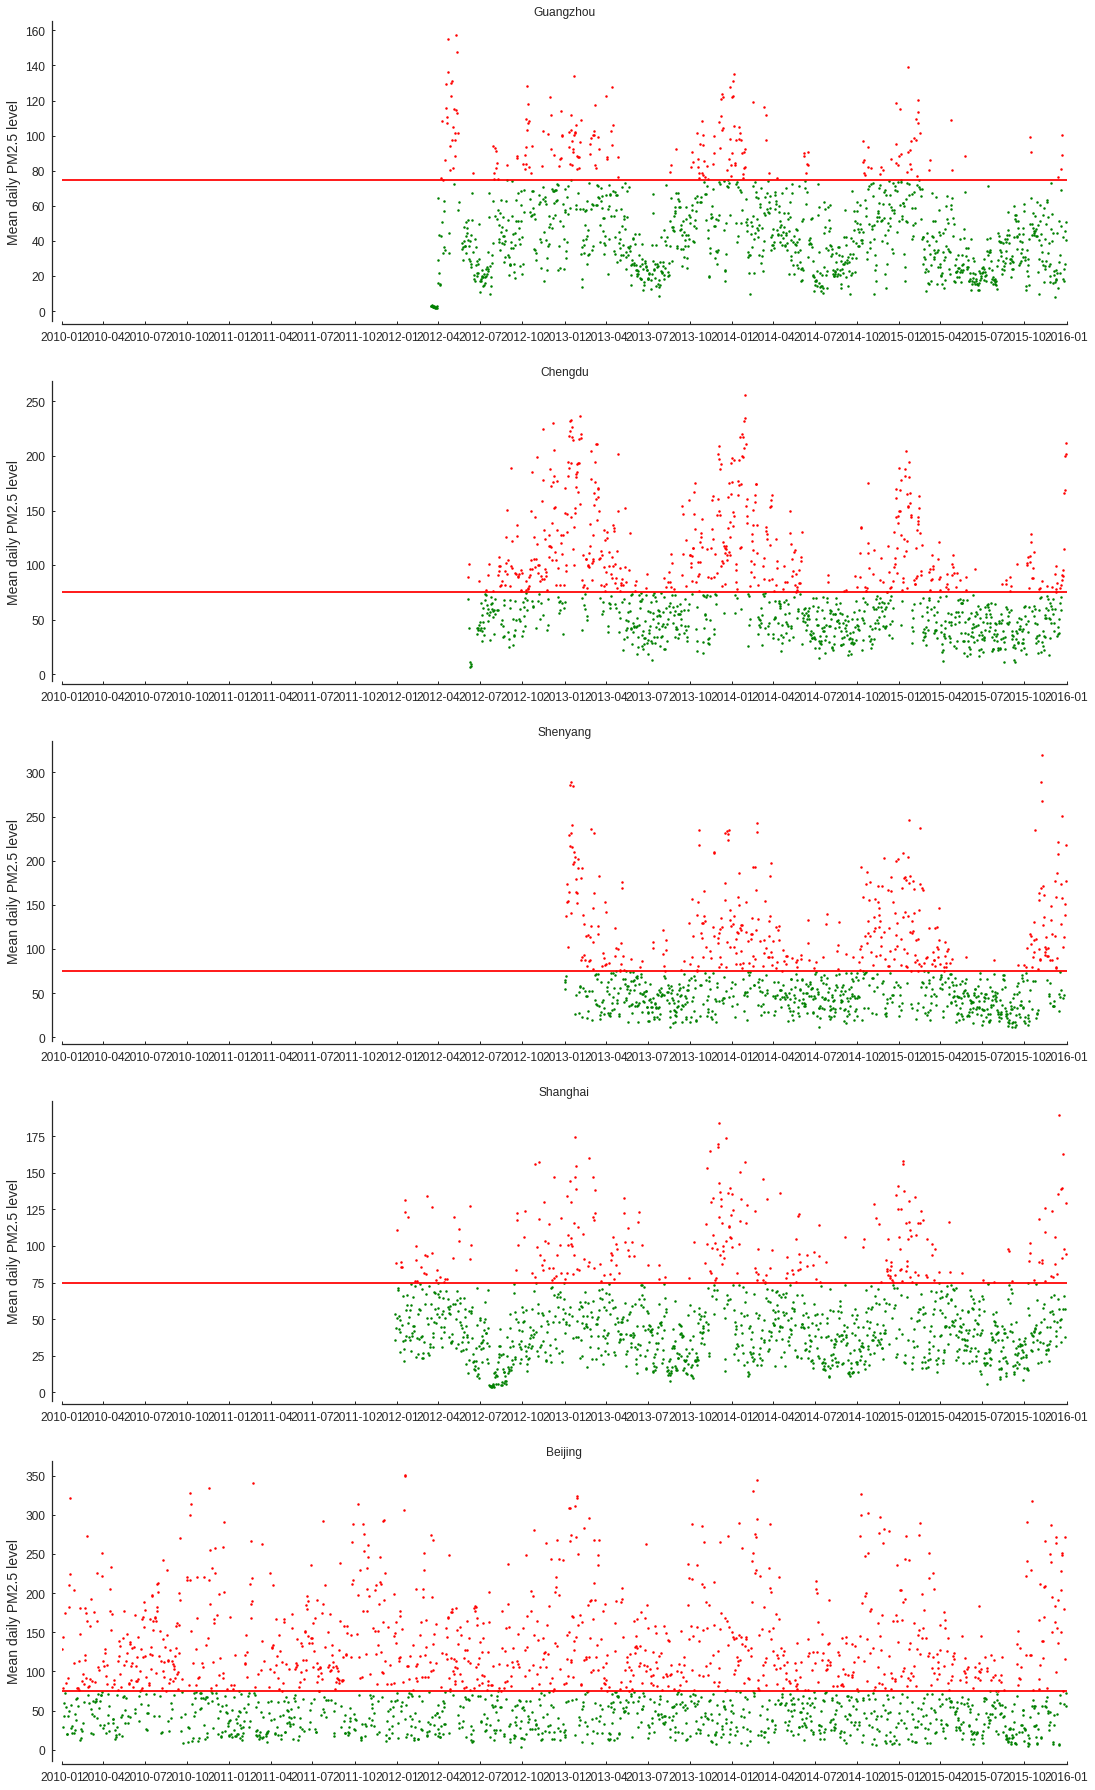

In [326]:
plt.style.use('seaborn-white')
fig,axes = plt.subplots(5,1,figsize=(18,32))
for i,city in enumerate(dic_df_cities.keys()):
    ax = axes[i]
    df_city = dic_df_cities[city]
    PM_cols = df_city.columns[df_city.columns.str.contains('PM')]
    df_city_daily_mean = df_city[PM_cols].mean(axis=1).resample('D').mean()
    ax.plot(df_city_daily_mean[df_city_daily_mean<75],linestyle='None',marker='o',color='green',markersize=2.5)
    ax.plot(df_city_daily_mean[df_city_daily_mean>=75],linestyle='None',marker='o',color='red',markersize=2.5)
    ax.axhline(75,color='red')
    ax.set_xlim(left=pd.to_datetime('2010-1-1'),right=pd.to_datetime('2016-1-1'))
    ax.set_title(city)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3,bymonthday=1))
    ax.tick_params(axis='x', labelrotation = 45)
    ax.set_ylabel('Mean daily PM2.5 level')
    beautify_axis(ax)
    

## Variation of PM2.5 levels across months of the year

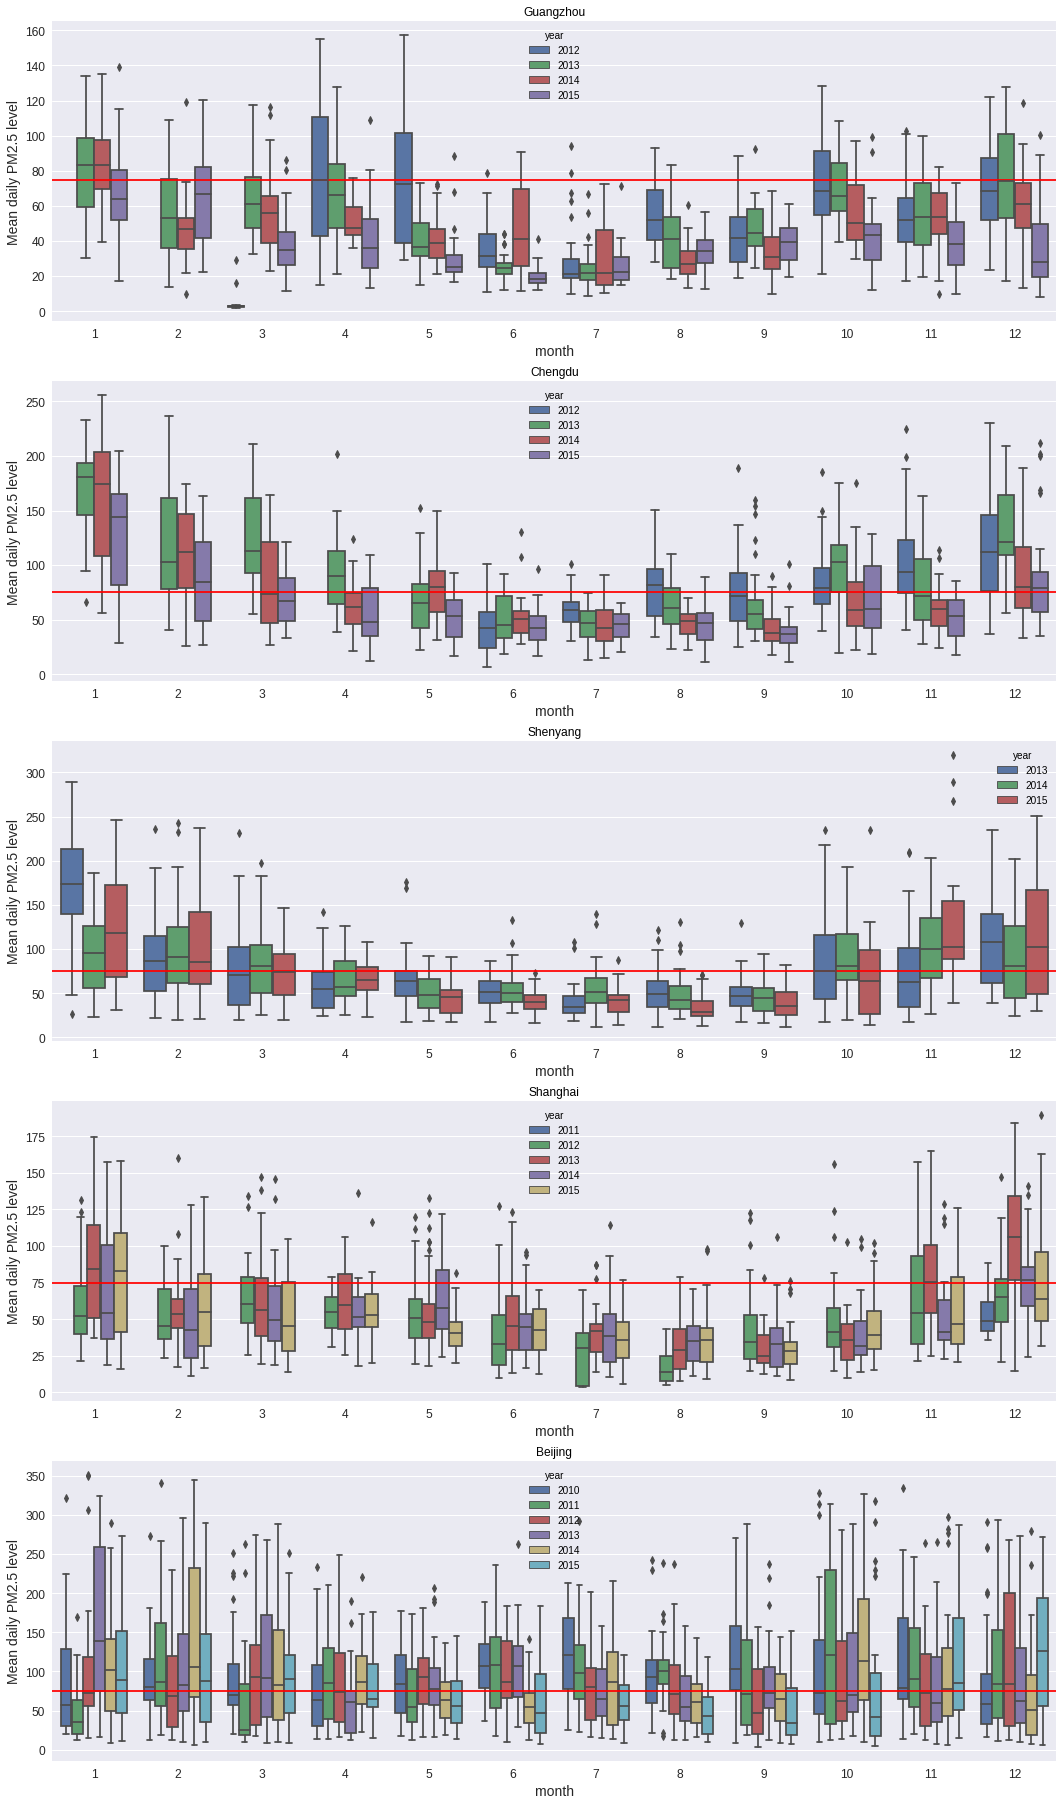

In [579]:
fig,axes = plt.subplots(5,1,figsize=(18,32))
for i,city in enumerate(dic_df_cities.keys()):
    ax = axes[i]
    df_city = dic_df_cities[city]
    PM_cols = df_city.columns[df_city.columns.str.contains('PM')]
    df_city_daily_mean = df_city[PM_cols].mean(axis=1).resample('D').mean().to_frame().rename({0:'Mean daily PM2.5 level'},axis=1)
    df_city_daily_mean ['month'] = df_city_daily_mean.index.month
    df_city_daily_mean ['year'] = df_city_daily_mean.index.year
    sns.boxplot(x='month',y='Mean daily PM2.5 level',hue='year',data=df_city_daily_mean,ax=ax)
    #ax.plot(df_city_daily_mean[df_city_daily_mean<75],linestyle='None',marker='o',color='green',markersize=2.5)
    #ax.plot(df_city_daily_mean[df_city_daily_mean>=75],linestyle='None',marker='o',color='red',markersize=2.5)
    ax.axhline(75,color='red')
    #ax.set_xlim(left=df_['2010'].index[0],right=pd.to_datetime('2016-1-1'))
    ax.set_title(city)
    #ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3,bymonthday=1))
    #ax.tick_params(axis='x', labelrotation = 45)

## Number of days above the threshold in each month in each city

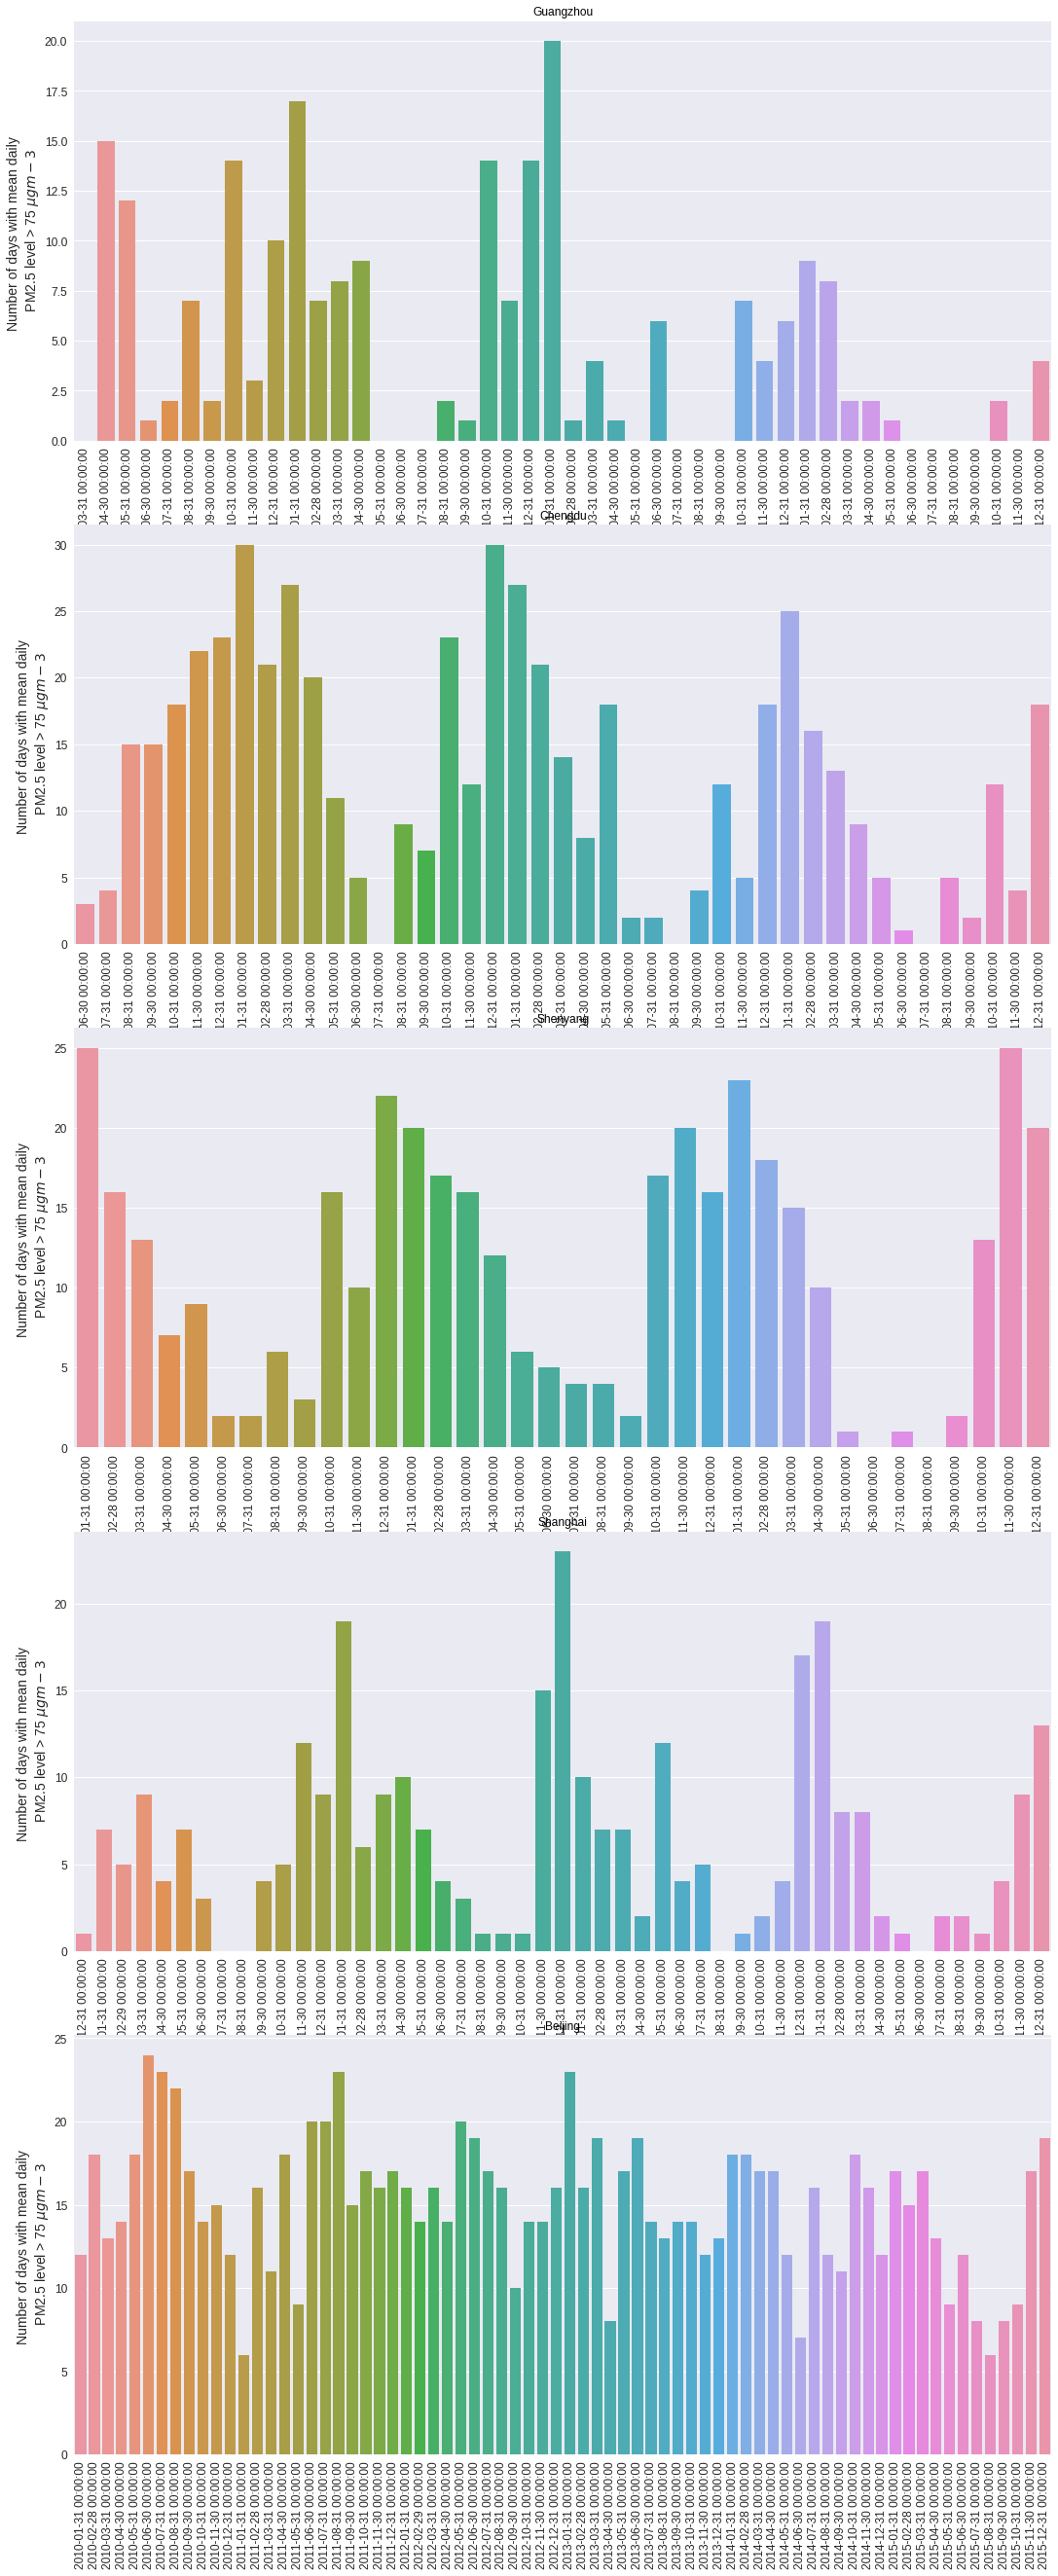

In [554]:
fig,axes = plt.subplots(5,1,figsize=(18,46))
date_format = mdates.DateFormatter('%b')
for i,city in enumerate(dic_df_cities.keys()):
    ax = axes[i]
    df_city = dic_df_cities[city]
    PM_cols = df_city.columns[df_city.columns.str.contains('PM')]
    df_city_daily_mean = df_city[PM_cols].mean(axis=1).resample('D').mean().fillna(method='ffill').to_frame().rename({0:'Mean daily PM2.5 level'},axis=1)
    mask = df_city_daily_mean['Mean daily PM2.5 level']>75
    df_city_daily_mean['flag'] = 0
    df_city_daily_mean.loc[mask,'flag'] = 1
    df_exceed_monthly = df_city_daily_mean['flag'].resample('M').sum()
    sns.barplot(x=df_exceed_monthly.index,y=df_exceed_monthly.values,ax=ax)
#     ax.xaxis_date() 
#     ax.xaxis.set_major_locator(mdates.AutoDateLocator()) 
#     ax.xaxis.set_major_formatter(mdates.DateFormatter("%y-%m"))
    ax.set_ylabel('Number of days with mean daily \n PM2.5 level > 75 $\mu g m-3$ ')

    ax.set_title(city)
    #ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.tick_params(axis='x', labelrotation = 90)


Visual inspection of the top figure reveals that:
- **Guangzhou:** The number of days above the exceedance threshold has been significantly reduced in 2015-2016 in comparison to previous years,
- **Chengdu:** While the number of days exceeding the threshold in each year has been decreasing steadily over time, the end of december surge is still concerning,
- **Shenyang:** A remarkble improvement in terms of frequency of days above the threshold is observed from May to October 2015, however, the rest of the year has not shown any sign of improvements,
- **Shanghai:** We did not observe any significant changes in the frequency of exceedance, 
- **Beijing:** While we see a slight improvement from May to October 2015 in comparison to previous years, the number of days above the threshold is alarmingly high in Beijing.

# Downsampling the data from hourly to daily

In [12]:
def hourly_to_daily_features(df_hourly_city,city):
    df_daily = pd.DataFrame()
    df_hourly = df_hourly_city.copy()
    try:
        df_hourly = df_hourly.drop(['year','month','day','hour','season'],axis=1)
    except KeyError:
        pass
    PM_cols = df_hourly.columns[df_hourly.columns.str.contains('PM')]
    df_daily['max_pm'] = df_hourly[PM_cols].max(axis=1).resample('D').max()
    df_daily['min_pm'] = df_hourly[PM_cols].min(axis=1).resample('D').min()
    df_daily['mean_pm'] = df_hourly[PM_cols].mean(axis=1).resample('D').mean()
    df_daily['prevailing_cbwd'] = df_hourly['cbwd'].resample('D').agg(lambda x:x.value_counts().index[0] if x.value_counts().shape[0]>0 else np.nan)
    for feature in ['DEWP', 'HUMI', 'PRES', 'TEMP', 'Iws', 'precipitation','Iprec']:
        df_daily['max_'+feature] = df_hourly[feature].resample('D').max()
        df_daily['min_'+feature] = df_hourly[feature].resample('D').min()
        df_daily['mean_'+feature] = df_hourly[feature].resample('D').mean()
    df_daily['city'] = city
    df_daily['year'] = df_daily.index.year
    df_daily['month'] = df_daily.index.month
    df_daily['day'] = df_daily.index.day
    df_daily = df_daily[['city','year','month','day'] + df_daily.columns[:-4].to_list()]
    return df_daily
    

In [13]:
dic_df_daily = {}
for city in cities:
    df_city = dic_df_cities[city]
    df_daily = hourly_to_daily_features(df_city,city)
    df_daily.fillna(method='ffill',inplace=True)   ### Filling the non-values by propagating the last valid observation 
    df_daily.replace({'NE':np.pi/4,'SE':3*(np.pi/4),'SW':-3*(np.pi/4),'NW':-np.pi/4},inplace=True) ## Converting wind direction to degree
    print(f'Number of rows with NaN values in {city} dataframe: {df_daily[df_daily.isnull().any(axis=1)].shape[0]}')
    dic_df_daily[city] = df_daily
    

Number of rows with NaN values in Guangzhou dataframe: 0
Number of rows with NaN values in Chengdu dataframe: 0
Number of rows with NaN values in Shenyang dataframe: 0
Number of rows with NaN values in Shanghai dataframe: 0
Number of rows with NaN values in Beijing dataframe: 0


# Schematic plots

In [368]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [379]:
decomp_city = seasonal_decompose(df_city['mean_pm'],model='additive')

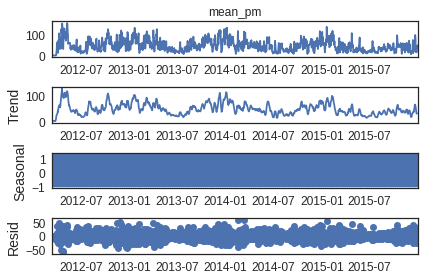

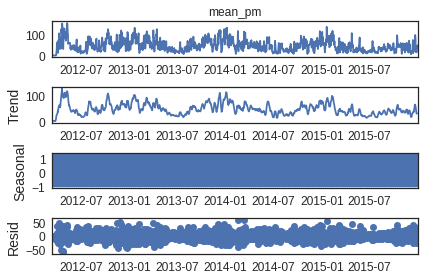

In [382]:
decomp_city.plot()

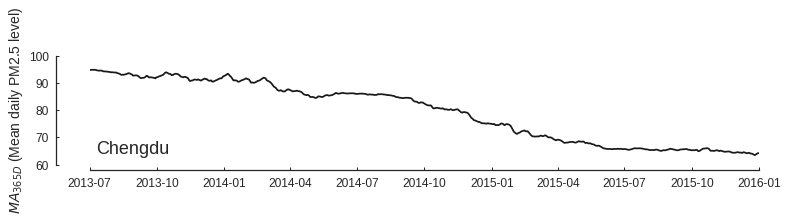

In [425]:
fig,ax = plt.subplots(1,1,figsize=(12,2))
city = 'Chengdu'
df_city = df_agg[df_agg['city']==city].copy()
df_city.index = df_city['date']
ax.plot(df_city['mean_pm'].rolling(365).mean(),color='black',alpha=0.9)
#decomp_city = seasonal_decompose(df_city['mean_pm']**0.5,model='additive')
#ax.plot(decomp_city.trend,color='red')

ax.set_xlim((pd.to_datetime('2013-7-1'),pd.to_datetime('2016-1-1')))
ax.set_ylim((60,100))
#ax.set_yticks([0,1,2,3,4])
#ax.set_yticklabels(cities)
ax.set_ylabel('$MA_{365D}$ (Mean daily PM2.5 level)')
beautify_axis(ax,bottom_space=-0.02)
#ax.set_title('Trend',fontsize=18)
ax.text(0.01,0.1,city,transform=ax.transAxes,fontsize=18)
#ax.spines['left'].set_bounds((0,4))


beautify_axis(ax,bottom_space=0.05,left_space=0.05)

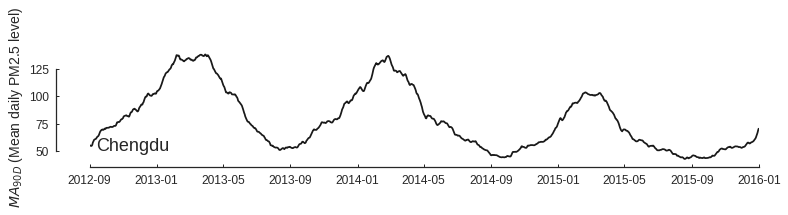

In [439]:
fig,ax = plt.subplots(1,1,figsize=(12,2))
city = 'Chengdu'
df_city = df_agg[df_agg['city']==city].copy()
df_city.index = df_city['date']
ax.plot(df_city['mean_pm'].rolling(90).mean(),color='black',alpha=0.9)
#decomp_city = seasonal_decompose(df_city['mean_pm']**0.5,model='additive')
#ax.plot(decomp_city.trend,color='red')

ax.set_xlim((pd.to_datetime('2012-9-1'),pd.to_datetime('2016-1-1')))
ax.set_ylim((40,140))
#ax.set_yticks([0,1,2,3,4])
#ax.set_yticklabels(cities)
ax.set_ylabel('$MA_{90D}$ (Mean daily PM2.5 level)')
beautify_axis(ax,bottom_space=0.05,left_space=0.05)
ax.text(0.01,0.1,city,transform=ax.transAxes,fontsize=18)
ax.spines['left'].set_bounds((50,125))




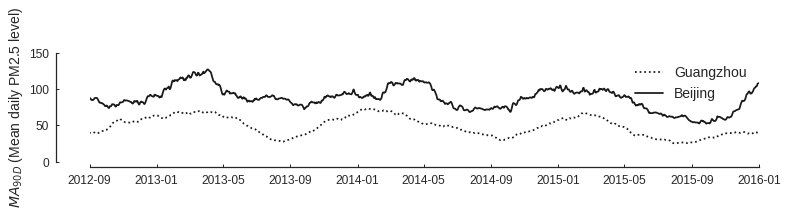

In [447]:
fig,ax = plt.subplots(1,1,figsize=(12,2))
city = cities[0]
df_city = df_agg[df_agg['city']==city].copy()
df_city.index = df_city['date']
ax.plot(df_city['mean_pm'].rolling(90).mean(),color='black',alpha=0.9,linestyle=':',label=city)

city = cities[-1]
df_city = df_agg[df_agg['city']==city].copy()
df_city.index = df_city['date']
ax.plot(df_city['mean_pm'].rolling(90).mean(),color='black',alpha=0.9,linestyle='-',label=city)


ax.set_xlim((pd.to_datetime('2012-9-1'),pd.to_datetime('2016-1-1')))
ax.set_ylim((0,150))
#ax.set_yticks([0,1,2,3,4])
#ax.set_yticklabels(cities)
ax.set_ylabel('$MA_{90D}$ (Mean daily PM2.5 level)')
beautify_axis(ax,bottom_space=0.05,left_space=0.05)
#ax.text(0.01,0.1,city,transform=ax.transAxes,fontsize=18)
ax.spines['left'].set_bounds((0,150))
ax.legend(loc=0,fontsize=14)

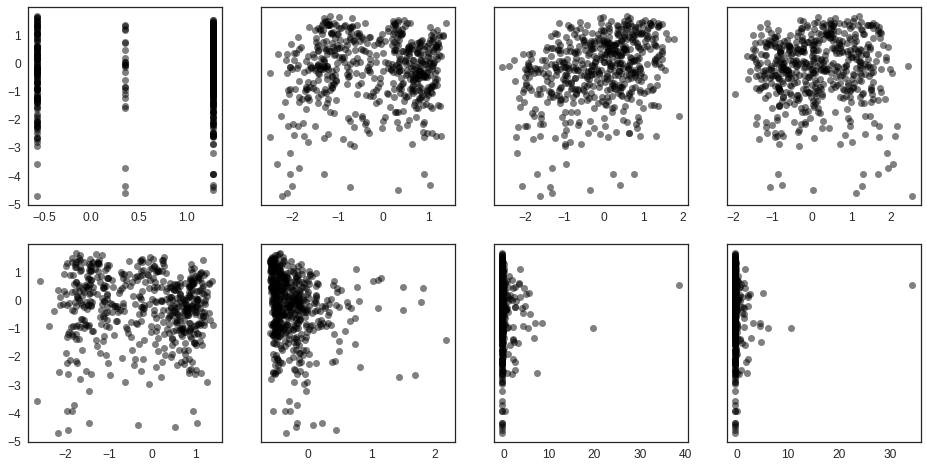

In [459]:
fig,axes = plt.subplots(2,4,figsize=(16,8),sharey=True)
df_plot= df_agg_std[df_agg_std['city']==city].sample(1000)
for i,covar in enumerate(meteo_vars_to_normalize):
    ax=axes[i//4,i%4]
    ax.plot(df_plot[covar],np.log(df_plot['mean_pm']),linestyle='None',marker='o',color='black',alpha=0.5)


## Examining the potential association between meteorological covariates and mean daily PM2.5

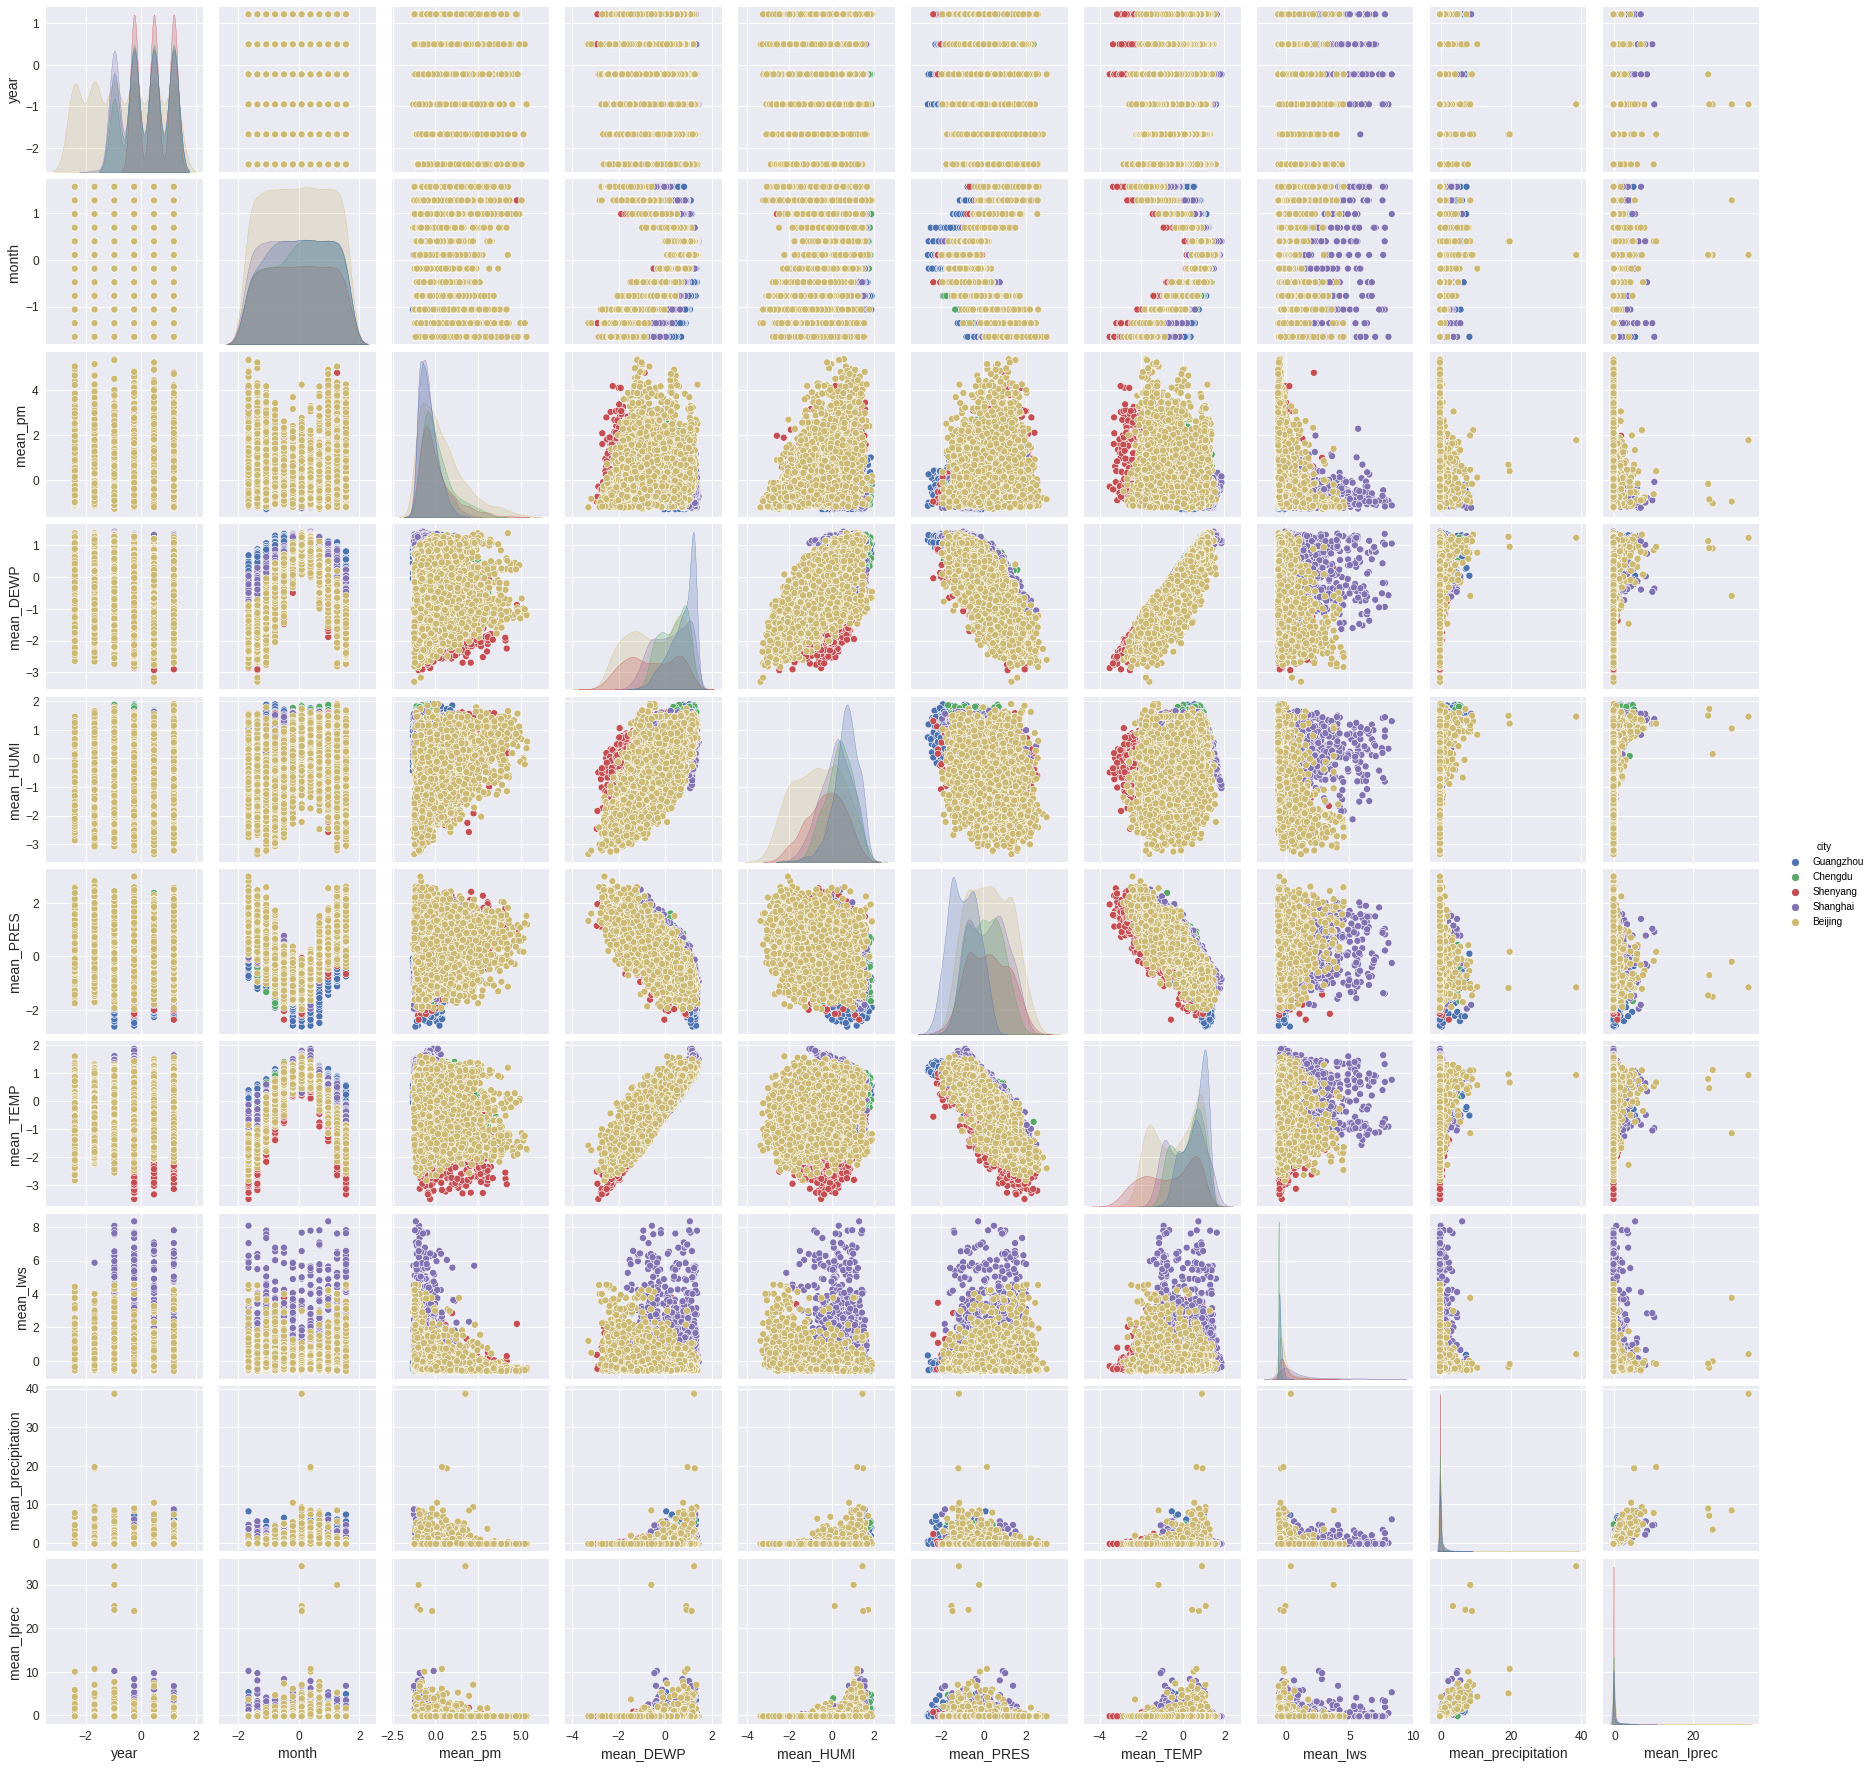

In [703]:
sns.pairplot(df_agg_std[['city','year','month','mean_pm','mean_DEWP','mean_HUMI','mean_PRES','mean_TEMP','mean_Iws','mean_precipitation','mean_Iprec']], hue="city")

In [566]:
features = ['mean_DEWP','mean_HUMI','mean_PRES','mean_TEMP','mean_Iws','mean_precipitation','mean_Iprec']

print("Correlation between Mean daily PM2.5 and each meteorological feature:")
print(df_agg[features ].corrwith(df_agg["mean_pm"]))


print("\nCorrelation between log-scale Mean daily PM2.5 and each meteorological feature:")
print(df_agg[features ].corrwith(np.log(df_agg["mean_pm"])))

Correlation between Mean daily PM2.5 and each meteorological feature:
month                -0.059988
mean_DEWP            -0.205049
mean_HUMI             0.063021
mean_PRES             0.226104
mean_TEMP            -0.294608
mean_Iws             -0.204485
mean_precipitation   -0.084658
mean_Iprec           -0.080878
dtype: float64

Correlation between log-scale Mean daily PM2.5 and each meteorological feature:
month                -0.064345
mean_DEWP            -0.176353
mean_HUMI             0.053220
mean_PRES             0.206872
mean_TEMP            -0.256779
mean_Iws             -0.264932
mean_precipitation   -0.098905
mean_Iprec           -0.097651
dtype: float64


**We observed a moderate negative correlation between mean daily temperature and mean PM2.5 level which is in agrrement with the seasonal pattern of data with lows in summer and highs in winter**

## Examining the data for statistical stationary:
 A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time. Most statistical forecasting methods are based on the assumption that the time series can be rendered approximately stationary. Our exploratory analysis depicted a seasonal pattern in PM2.5 measurements (seasonal lows in summer and peaks in January). This is better depicted in the following figure which shows the 30D moving averge and STD of mean PM2.5 levels for each cityi. We also observed a downward pattern in PM2.5 levels in Guangzhou and Chengdu. We will use Augmented Dickey-Fuller test to examine whether the data is stationary or not. The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary (evidently meteorological have a strong seasonality pattern and thus are not stationary):

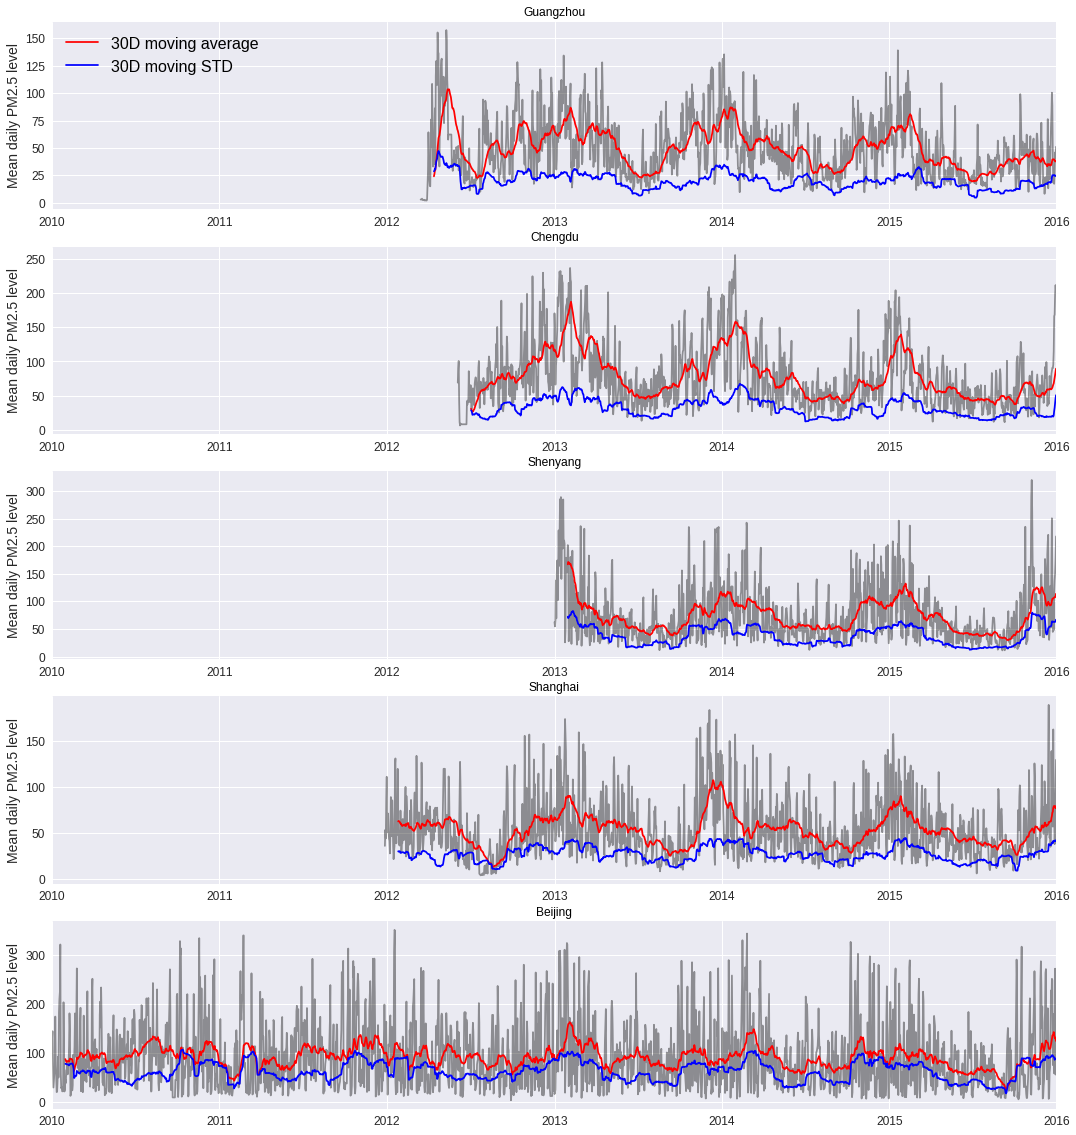

In [53]:
fig,axes = plt.subplots(5,1,figsize=(18,20))
for i,city in enumerate(dic_df_daily.keys()):
    ax = axes[i]
    df_daily = dic_df_daily[city]
    ax.plot(df_daily['mean_pm'],alpha=0.4,color='black')
    ax.plot(df_daily['mean_pm'].rolling(30).mean(),label='30D moving average',color='red')
    ax.plot(df_daily['mean_pm'].rolling(30).std(),label='30D moving STD',color='blue')
    ax.set_xlim(left=pd.to_datetime('2010-1-1'),right=pd.to_datetime('2016-1-1'))
    ax.set_title(city)
    #ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3,bymonthday=1))
    #ax.tick_params(axis='x', labelrotation = 45)
    ax.set_ylabel('Mean daily PM2.5 level')
axes[0].legend(loc=2,fontsize=16)
plt.show()

In [14]:
def tsplot(y,city, lags=None, figsize=(12, 7), syle='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=(12, 7))
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        mean_std_ax = plt.subplot2grid(layout, (2, 0), colspan=2)
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        hypothesis_result = "We reject stationarity" if p_value <= 0.05 else "We can not reject stationarity"
        ts_ax.set_title(
            city + ' - Time Series stationary analysis Plots\n Dickey-Fuller: p={0:.5f} Result: {1}'.format(p_value, hypothesis_result))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

        rolmean = y.rolling(window=12).mean()
        rolstd = y.rolling(window=12).std()

        # Plot rolling statistics:
        orig = plt.plot(y, label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label='Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
       # plt.text(-0.1,0.1,city,fontsize=16,transform)

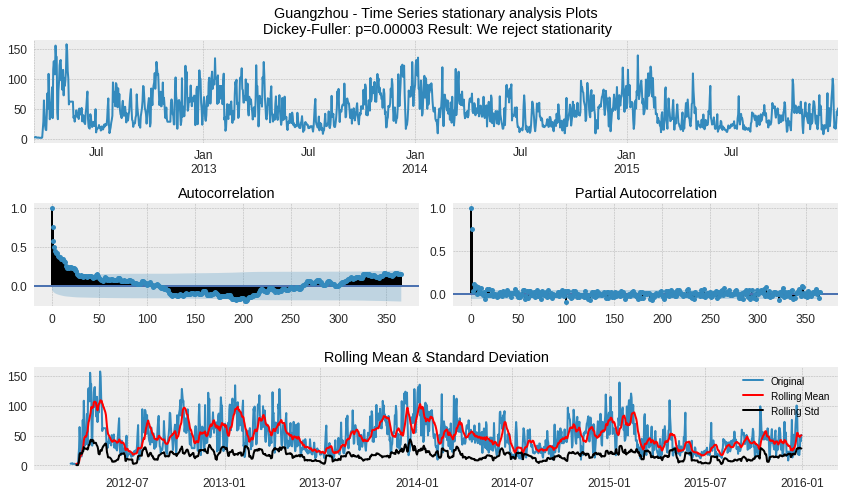

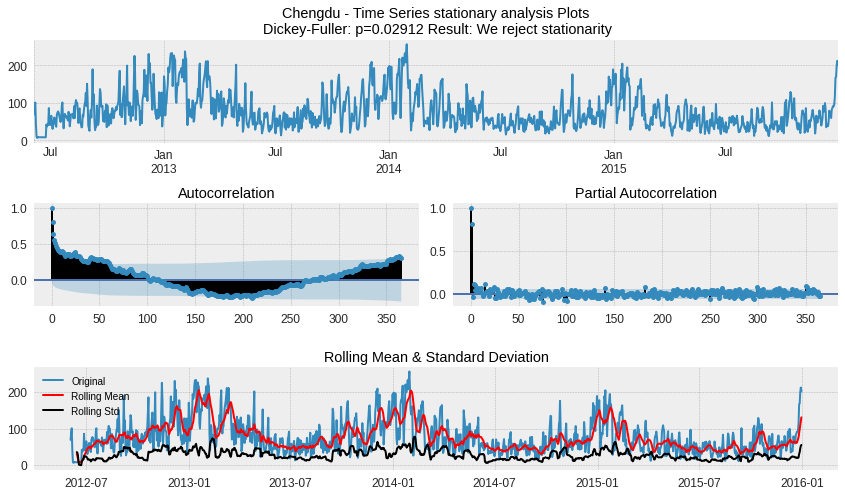

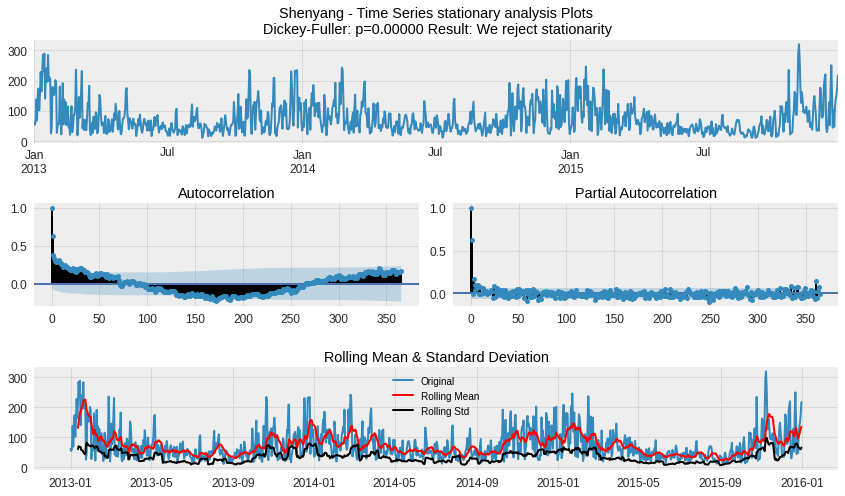

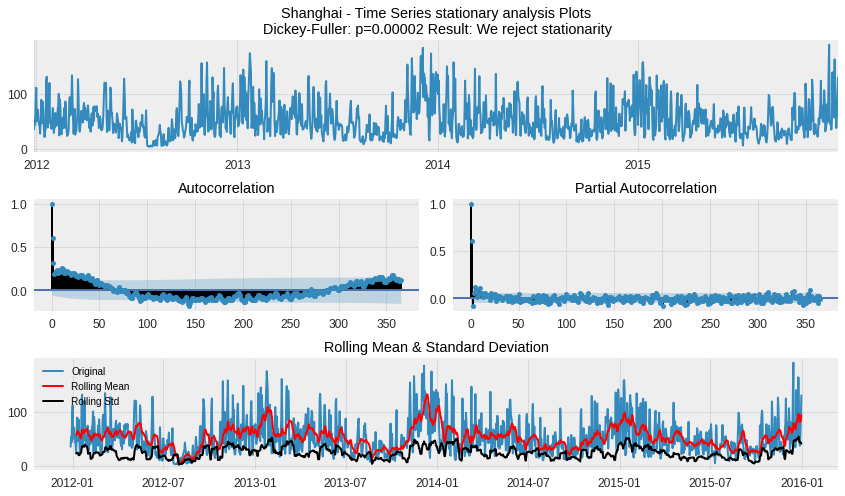

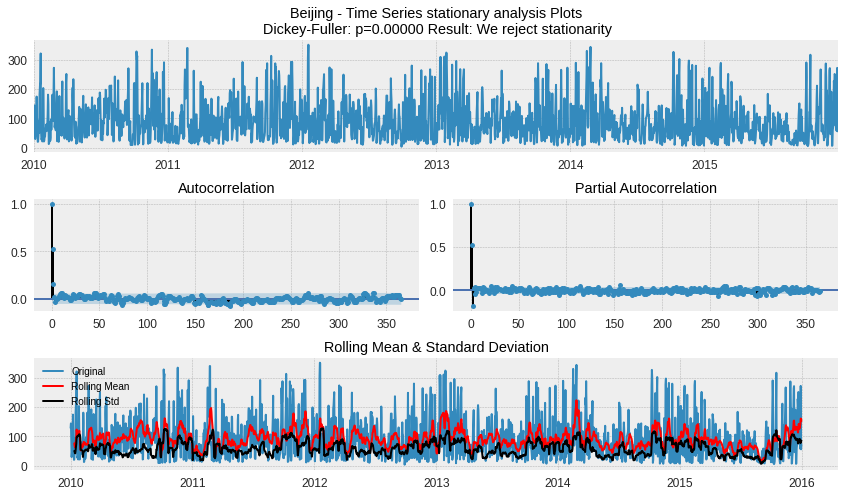

In [62]:
for city in cities:
    tsplot(dic_df_daily[city]['mean_pm'],city,lags=365)

In [700]:
## Differencing the data to make them stationary

### Merging the dataframes

In [489]:
df_agg = pd.DataFrame()
for i,city in enumerate(cities):
    df_temp = dic_df_daily[city].copy()
    df_temp['date'] = df_temp[['year','month','day']].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
    df_temp['date'] = pd.to_datetime(df_temp['date'])
    #df_temp = df_temp[df_temp['date']>='2013-1-1']
    df_temp['days_passed'] = (df_temp['date'] - datetime(2010,1,1)).dt.days
    df_temp['years_passed'] = df_temp['days_passed']/365
    df_temp['sqrt_mean_pm'] = np.sqrt(df_temp['mean_pm'])
    df_temp['log_mean_pm'] = np.log(df_temp['mean_pm'])
    df_temp['mean_pm_yesterday'] = df_temp['mean_pm'].shift().fillna(method='bfill')
    df_temp['sqrt_mean_pm_yesterday'] = df_temp['sqrt_mean_pm'].shift().fillna(method='bfill')
    df_temp['log_mean_pm_yesterday'] = df_temp['log_mean_pm'].shift().fillna(method='bfill')
    df_temp['city_code'] = i
    df_agg = pd.concat([df_agg,df_temp])
df_agg.reset_index(inplace=True,drop=True)
df_agg['day_of_week'] = df_agg['date'].dt.dayofweek
df_agg['is_holiday'] = 0

for row in df_agg.index:
    if is_workday(df_agg.loc[row,'date'])==False:
        df_agg.loc[row,'is_holiday'] = 1

df_agg.tail(5)

city  year  month  day  max_pm  min_pm     mean_pm  prevailing_cbwd  \
7439  Beijing  2015     12   27   155.0    15.0   58.187500         0.785398   
7440  Beijing  2015     12   28   281.0    48.0  115.312500        -0.785398   
7441  Beijing  2015     12   29   360.0   165.0  272.313725         2.356194   
7442  Beijing  2015     12   30   331.0     5.0   55.822464        -0.785398   
7443  Beijing  2015     12   31   242.0    11.0   72.753472        -0.785398   

      max_DEWP  min_DEWP  ...  days_passed  years_passed  sqrt_mean_pm  \
7439     -10.0     -20.0  ...         2186      5.989041      7.628073   
7440      -7.0     -14.0  ...         2187      5.991781     10.738366   
7441      -4.0      -8.0  ...         2188      5.994521     16.501931   
7442      -5.0     -11.0  ...         2189      5.997260      7.471443   
7443      -8.0     -12.0  ...         2190      6.000000      8.529565   

      log_mean_pm  mean_pm_yesterday  sqrt_mean_pm_yesterday  \
7439     4.063671         179.888889               13.412266   
7440     4.747646          58.187500                7.628073   
7441     5.606955         115.312500               10.738366   
7442     4.022176         272.313725               16.501931   
7443     4.287077          55.822464                7.471443   

      log_mean_pm_yesterday  city_code  day_of_week  is_holiday  
7439               5.192339          4            6           1  
7440               4.063671          4            0           0  
7441               4.747646          4            1           0  
7442               5.606955          4            2           0  
7443               4.022176          4            3           0  

[5 rows x 40 columns]

## Holidyas and weekends are not different!

<AxesSubplot:>

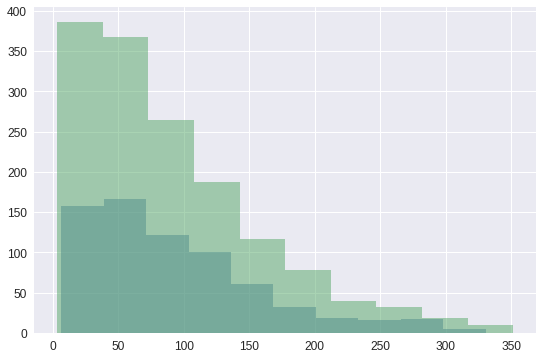

In [17]:
fig,ax = plt.subplots(1,1,figsize=(9,6))
df_agg[(df_agg['city_code']==4)&(df_agg['is_holiday']==1)]['mean_pm'].hist(alpha=0.5,ax=ax)
df_agg[(df_agg['city_code']==4)&(df_agg['is_holiday']==0)]['mean_pm'].hist(alpha=0.5,ax=ax)

In [502]:
meteo_vars_to_normalize = ['prevailing_cbwd','mean_HUMI','mean_PRES','mean_Iws','mean_precipitation']
time_series_vars_to_normalize = ['years_passed','mean_pm','sqrt_mean_pm','mean_pm_yesterday','sqrt_mean_pm_yesterday','log_mean_pm','log_mean_pm_yesterday']
vars_to_normalize = meteo_vars_to_normalize + time_series_vars_to_normalize
df_norm = df_agg[vars_to_normalize].copy()
scaler = StandardScaler()
X_std = scaler.fit_transform(df_norm)
#df_norm = X_std
df_norm = pd.DataFrame(data=X_std,columns=df_norm.columns,index=df_norm.index)
df_agg_std = df_agg.drop(vars_to_normalize,axis=1).join(df_norm)
df_agg_std

city  year  month  day  max_pm  min_pm  max_DEWP  min_DEWP  \
0     Guangzhou  2012      3   15     4.0     1.0      17.3      15.1   
1     Guangzhou  2012      3   16     6.0     1.0      21.4      17.1   
2     Guangzhou  2012      3   17     6.0     1.0      20.6      19.2   
3     Guangzhou  2012      3   18     6.0     1.0      21.9      18.5   
4     Guangzhou  2012      3   19     5.0     1.0      22.1      18.3   
...         ...   ...    ...  ...     ...     ...       ...       ...   
7439    Beijing  2015     12   27   155.0    15.0     -10.0     -20.0   
7440    Beijing  2015     12   28   281.0    48.0      -7.0     -14.0   
7441    Beijing  2015     12   29   360.0   165.0      -4.0      -8.0   
7442    Beijing  2015     12   30   331.0     5.0      -5.0     -11.0   
7443    Beijing  2015     12   31   242.0    11.0      -8.0     -12.0   

      mean_DEWP  max_HUMI  ...  mean_PRES  mean_Iws  mean_precipitation  \
0     16.241667      97.0  ...  -0.557242 -0.560024           -0.159415   
1     19.283333      98.0  ...  -0.854952 -0.598741            0.261330   
2     19.975000      98.0  ...  -0.965231 -0.505422           -0.293288   
3     20.316667      98.0  ...  -0.904011 -0.550238           -0.293288   
4     19.500000      98.0  ...  -0.872563 -0.496204           -0.293288   
...         ...       ...  ...        ...       ...                 ...   
7439 -13.958333      85.0  ...   2.511268 -0.510783           -0.293288   
7440 -11.458333      85.0  ...   2.150662 -0.180422           -0.293288   
7441  -6.625000      92.0  ...   1.530083 -0.602897           -0.293288   
7442  -8.750000      92.0  ...   1.681035  0.256816           -0.293288   
7443 -10.083333      79.0  ...   1.890690 -0.336427           -0.293288   

      years_passed   mean_pm  sqrt_mean_pm  mean_pm_yesterday  \
0        -1.158617 -1.297864     -2.180334          -1.297960   
1        -1.156671 -1.300250     -2.193161          -1.297960   
2        -1.154726 -1.296204     -2.171568          -1.300348   
3        -1.152781 -1.283797     -2.109623          -1.296299   
4        -1.150835 -1.300467     -2.194341          -1.283882   
...            ...       ...           ...                ...   
7439      1.529845 -0.244306     -0.106560           2.081686   
7440      1.531790  0.846239      0.987406          -0.243546   
7441      1.533735  3.843472      3.014592           0.847887   
7442      1.535681 -0.289456     -0.161650           3.847558   
7443      1.537626  0.033765      0.210517          -0.288732   

      sqrt_mean_pm_yesterday  log_mean_pm  log_mean_pm_yesterday  
0                  -2.180165    -3.988344              -3.984709  
1                  -2.180165    -4.046595              -3.984709  
2                  -2.192996    -3.949236              -4.042923  
3                  -2.171395    -3.687741              -3.945626  
4                  -2.109428    -4.052016              -3.684298  
...                      ...          ...                    ...  
7439                1.929580     0.069899               1.614741  
7440               -0.105619     1.006049               0.070934  
7441                0.988754     2.182176               1.006484  
7442                3.016695     0.013107               2.181857  
7443               -0.160730     0.375673               0.014178  

[7444 rows x 40 columns]

In [468]:
# print(df_agg_std.shape)
# col = 'log_mean_pm'
# idx_outliers = df_agg_std[np.abs(df_agg_std[col]-df_agg_std[col].mean()) > (3.0*df_agg_std[col].std())].index
# df_agg_std.loc[idx_outliers,col] = np.nan
# df_agg_std.dropna(how='any',inplace=True)
# print(df_agg_std.shape)

In [503]:
df_train_mc = df_agg_std[df_agg_std['date']<='2015-10-1'].copy()
df_test_mc = df_agg_std[df_agg_std['date']>'2015-10-1'].copy()

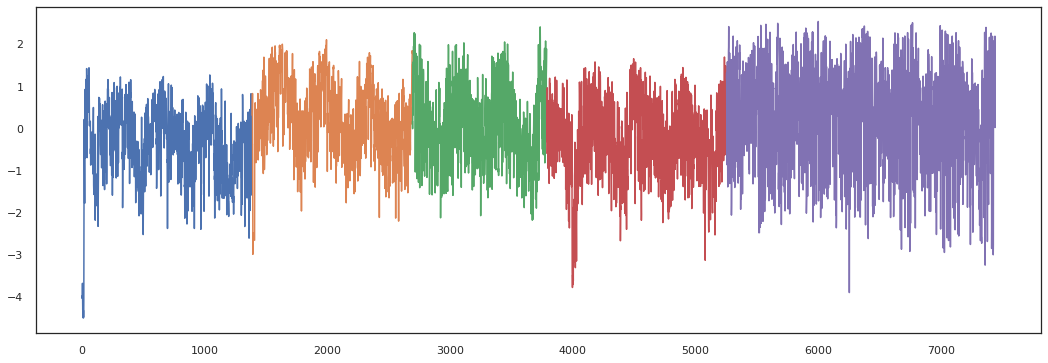

In [504]:
fig,ax = plt.subplots(1,1,figsize=(18,6))
for city in cities:
    df_temp = df_agg_std[df_agg_std['city']==city]
    ax.plot(df_temp['log_mean_pm'])

In [474]:
import pymc3 as pm
import theano.tensor as tt
import pickle
import scipy.stats as stats
import random
import arviz as az
from chinese_calendar import is_workday, is_holiday

In [505]:
omega = (2*np.pi)/365

In [506]:
X_exog = df_train_mc[meteo_vars_to_normalize]

In [507]:
X_exog

prevailing_cbwd  mean_HUMI  mean_PRES  mean_Iws  mean_precipitation
0            1.284271   1.337069  -0.557242 -0.560024           -0.159415
1            0.353937   1.477752  -0.854952 -0.598741            0.261330
2           -1.506732   1.400377  -0.965231 -0.505422           -0.293288
3           -0.576397   1.135424  -0.904011 -0.550238           -0.293288
4            1.284271   1.121356  -0.872563 -0.496204           -0.293288
...               ...        ...        ...       ...                 ...
7348        -0.576397  -0.116653   0.054112 -0.574929           -0.293288
7349         1.284271   1.149492   0.926277 -0.524313           -0.140290
7350        -0.576397   1.442581   1.517504 -0.474037            1.791311
7351         1.284271   1.065083   0.557284 -0.335973            1.217568
7352        -0.576397  -1.221014  -0.147157  1.679024           -0.293288

[6989 rows x 5 columns]

<AxesSubplot:>

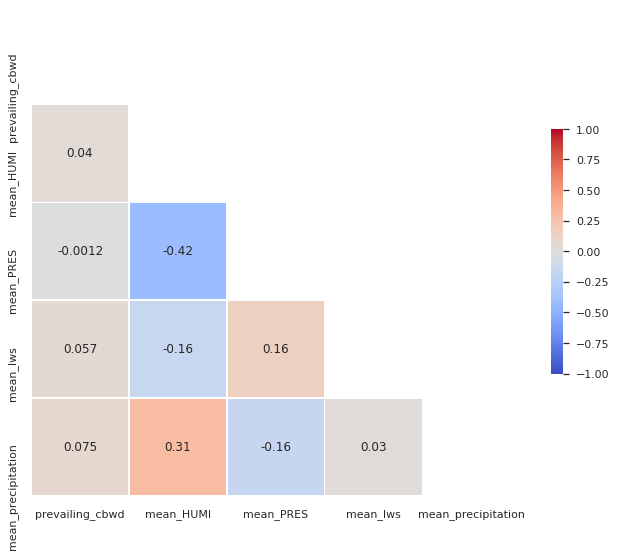

In [478]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)

# Compute the correlation matrix
corr = X_exog.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(230, 20, as_cmap=True)
cmap = sns.color_palette("coolwarm", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, center=0,vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)

$$
\begin{align*}
Z_{i,t} &= \log(y_{i,t}) \\\\
y_{i,t} &= \eta_i + \rho_i t + \gamma sin(\omega t) + \delta \cos(\omega t) + \mathbf{X} \beta + \epsilon_{i,t}  \\\\ 
\epsilon_{i,t} &= \phi_{1,i} \epsilon_{t-1,i}+\phi_{2,i} \epsilon_{t-2,i}+\cdots+w_{t} , \, w_{t} \sim \mathcal{N}(0,\sigma^2) \\\
\end{align*}
$$

$$
\begin{align*}
\eta_i,\rho_i,\gamma,\delta &\sim \mathcal{N}(0,2), \\\\
\mathbf{X} \sim \mathcal{N}(\boldsymbol{\mu}, \mathbf{\Sigma}).
\end{align*}
$$

<font size="5"> $Z_{i,t}$: PM2.5 level in city $i$ at time $t$, </font> <br>
<font size="5"> $\eta_{i}$: Base PM2.5 level in city $i$, </font> <br>
<font size="5"> $\rho_{i}$: PM2.5 trend in city $i$, </font> <br>
<font size="5"> $\gamma, \delta$: Amplitude of seasonality terms, </font> <br>
<font size="5"> $\omega$: Angular frequency of seasonality ($\frac{2 \pi}{365}$), </font> <br>
<font size="5"> $X$: Meteorological covariates, </font> <br>
<font size="5"> $B$: Design matrix, </font> <br>
<font size="5"> $\epsilon_{i,t}$: Autoregressive residual.</font>




<font size="3"> $\omega=\frac{2 \pi}{365}$: Angular frequency of seasonality, </font>

In [508]:
with pm.Model() as pm25model:
#     sigma = pm.HalfNormal('sigma',sigma=2)
#     epsilon = pm.Normal('epsilon',mu=0,sigma=sigma,shape=5)
    
    rho = pm.Normal('rho',mu=0,sigma=2,shape=5)
    gamma = pm.Normal('gamma',mu=0,sigma=3)
    delta = pm.Normal('delta',mu=0,sigma=3)
    eta = pm.Normal('eta',mu=0,sigma=5,shape=5)
    
    beta_0 = pm.Normal('beta_0',mu=0,sigma=2)
    beta_1 = pm.Normal('beta_1',mu=0,sigma=2)
    beta_2 = pm.Normal('beta_2',mu=0,sigma=2)
    beta_3 = pm.Normal('beta_3',mu=0,sigma=2)
    beta_4 = pm.Normal('beta_4',mu=0,sigma=2)
    
    
    
    mu = rho[df_train_mc['city_code'].values] * df_train_mc['years_passed'].values + \
    gamma * tt.sin(omega*df_train_mc['days_passed'].values) + delta * tt.cos(omega*df_train_mc['days_passed'].values) + \
    eta[df_train_mc['city_code'].values]+ \
    beta_0 * X_exog.iloc[:,0] + beta_1 * X_exog.iloc[:,1] + beta_2 * X_exog.iloc[:,2] + beta_3 * X_exog.iloc[:,3] + beta_4 * X_exog.iloc[:,4] 

    epsilon = pm.HalfCauchy("epsilon", 2)
    
    y = pm.Normal('y',mu=mu,sigma=epsilon,observed=df_train_mc['log_mean_pm'])
    

In [480]:
with pm25model:
    fit = pm.sample(2000,cores=4,tune=2000)#,target_accept=0.99,max_treedepth=15)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epsilon, beta_4, beta_3, beta_2, beta_1, beta_0, eta, delta, gamma, rho]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [01:15<00:00, 211.46draws/s]


In [518]:
import arviz as az
df_summary = az.summary(fit)

/home/arashs/anaconda3/envs/MLenv/lib/python3.6/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


/home/arashs/anaconda3/envs/MLenv/lib/python3.6/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


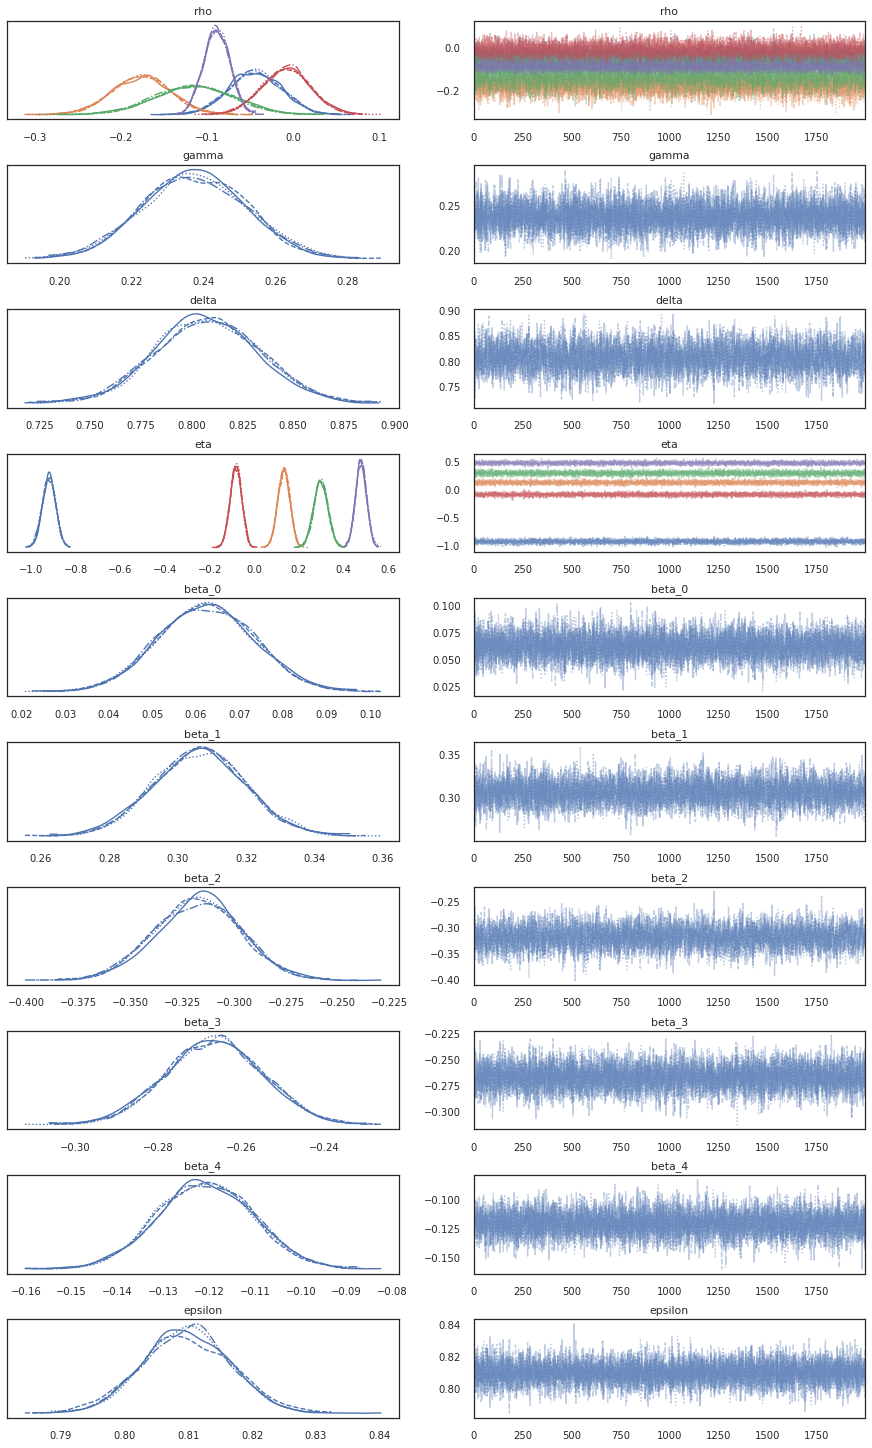

In [482]:
pm.traceplot(fit);

In [483]:
with pm25model:
    ppc = pm.sample_posterior_predictive(
        fit, var_names=fit.varnames+['y'], random_seed=42
    )

100%|██████████| 8000/8000 [00:25<00:00, 311.03it/s]


In [519]:
df_ppc.head(5)

rho_0     eta_0     rho_1     eta_1     rho_2     eta_2     rho_3  \
0 -0.055659 -0.939366 -0.162462  0.148057 -0.155963  0.301040 -0.023312   
1 -0.025533 -0.931114 -0.201033  0.150334 -0.043768  0.284689  0.013581   
2 -0.030803 -0.986333 -0.167771  0.129981 -0.109359  0.289284  0.024843   
3 -0.045197 -0.898331 -0.171374  0.177664 -0.055689  0.311394 -0.011129   
4 -0.027761 -0.904371 -0.193788  0.082475 -0.160081  0.312232 -0.012691   

      eta_3     rho_4     eta_4     gamma     delta   epsilon    beta_0  \
0 -0.100822 -0.088554  0.473660  0.233868  0.793903  0.809426  0.057685   
1 -0.067850 -0.101687  0.484879  0.234402  0.857223  0.801514  0.079125   
2 -0.112132 -0.082790  0.473788  0.254010  0.831235  0.806946  0.060035   
3 -0.073283 -0.094824  0.492349  0.232807  0.833875  0.802349  0.078387   
4 -0.078993 -0.087864  0.446537  0.244605  0.782835  0.818261  0.051306   

     beta_1    beta_2    beta_3    beta_4  
0  0.291738 -0.316656 -0.242463 -0.125845  
1  0.305851 -0.334483 -0.282873 -0.120842  
2  0.301316 -0.337379 -0.251647 -0.122039  
3  0.309020 -0.330794 -0.267686 -0.127294  
4  0.287491 -0.295187 -0.275008 -0.118775

In [537]:
df_summary

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
rho[0]  -0.045  0.030  -0.102    0.011      0.000      0.0   13447.0   8028.0   
rho[1]  -0.177  0.034  -0.242   -0.113      0.000      0.0   11618.0  11019.0   
rho[2]  -0.115  0.045  -0.202   -0.033      0.001      0.0    8090.0   8087.0   
rho[3]  -0.009  0.028  -0.061    0.046      0.000      0.0   11817.0   4279.0   
rho[4]  -0.089  0.015  -0.117   -0.061      0.000      0.0    7532.0   7532.0   
gamma    0.238  0.014   0.211    0.266      0.000      0.0    9010.0   9010.0   
delta    0.808  0.026   0.760    0.856      0.000      0.0    4982.0   4970.0   
eta[0]  -0.921  0.030  -0.978   -0.867      0.000      0.0    6346.0   6320.0   
eta[1]   0.133  0.027   0.085    0.185      0.000      0.0    9163.0   9094.0   
eta[2]   0.299  0.031   0.242    0.360      0.000      0.0    7888.0   7888.0   
eta[3]  -0.082  0.025  -0.131   -0.036      0.000      0.0    8321.0   7958.0   
eta[4]   0.480  0.024   0.434    0.526      0.000      0.0    5078.0   5078.0   
beta_0   0.062  0.011   0.042    0.083      0.000      0.0    8601.0   8601.0   
beta_1   0.306  0.013   0.281    0.332      0.000      0.0    6543.0   6543.0   
beta_2  -0.317  0.021  -0.357   -0.280      0.000      0.0    4786.0   4756.0   
beta_3  -0.266  0.012  -0.288   -0.245      0.000      0.0    8569.0   8565.0   
beta_4  -0.121  0.010  -0.140   -0.101      0.000      0.0    8770.0   8682.0   
epsilon  0.810  0.007   0.797    0.822      0.000      0.0   14013.0  14008.0   

         ess_bulk  ess_tail  r_hat  
rho[0]    13452.0    5983.0    1.0  
rho[1]    11596.0    6118.0    1.0  
rho[2]     8084.0    6907.0    1.0  
rho[3]    11803.0    6387.0    1.0  
rho[4]     7538.0    6869.0    1.0  
gamma      8994.0    6229.0    1.0  
delta      4986.0    6300.0    1.0  
eta[0]     6366.0    5963.0    1.0  
eta[1]     9162.0    6666.0    1.0  
eta[2]     7894.0    6541.0    1.0  
eta[3]     8319.0    6585.0    1.0  
eta[4]     5071.0    6004.0    1.0  
beta_0     8594.0    6784.0    1.0  
beta_1     6545.0    6712.0    1.0  
beta_2     4794.0    5611.0    1.0  
beta_3     8573.0    6818.0    1.0  
beta_4     8763.0    6107.0    1.0  
epsilon   14078.0    6543.0    1.0

In [582]:
cities

['Guangzhou', 'Chengdu', 'Shenyang', 'Shanghai', 'Beijing']

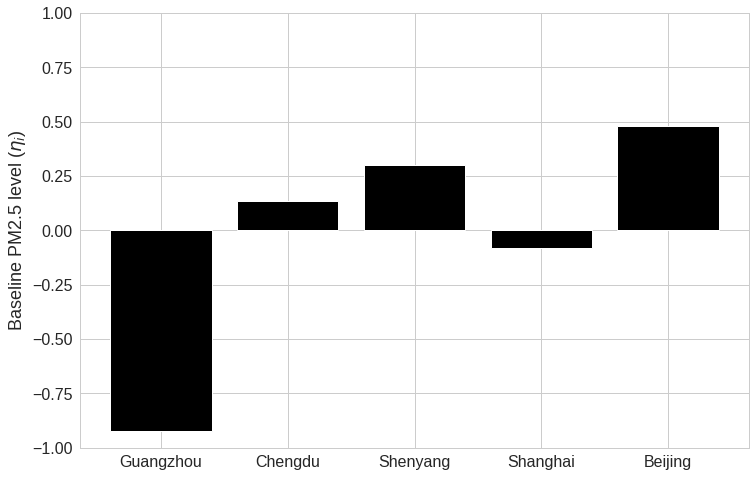

In [599]:
plt.style.use('seaborn-whitegrid')
df_eta = df_summary.loc[[idx for idx in df_summary.index if idx.startswith('eta')]]
fig,ax = plt.subplots(1,1,figsize=(12,8))
ax.bar(x=np.arange(5),height=df_eta['mean'],data=df_eta,color='black',alpha=1.0,tick_label=cities)


ax.set_ylim((-1.0,1.0))
ax.set_ylabel('Baseline PM2.5 level ($\eta_i$)',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)

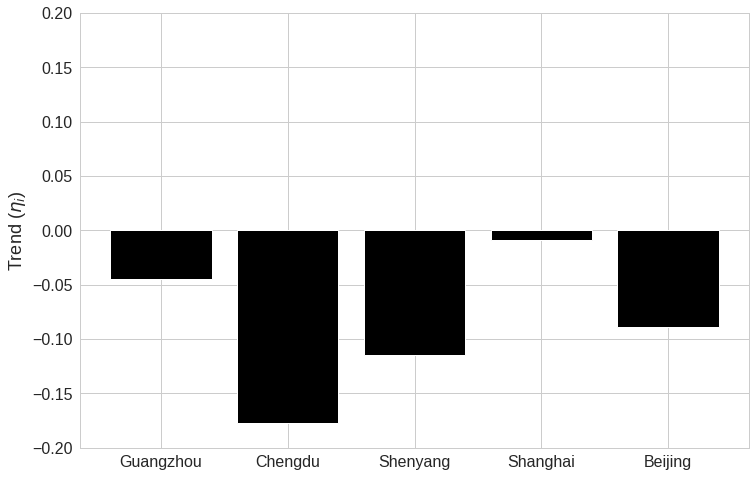

In [600]:
plt.style.use('seaborn-whitegrid')
df_rho = df_summary.loc[[idx for idx in df_summary.index if idx.startswith('rho')]]
fig,ax = plt.subplots(1,1,figsize=(12,8))
ax.bar(x=np.arange(5),height=df_rho['mean'],data=df_rho,color='black',alpha=1.0,tick_label=cities)


ax.set_ylim((-0.2,0.2))
ax.set_ylabel('Trend ($\eta_i$)',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)

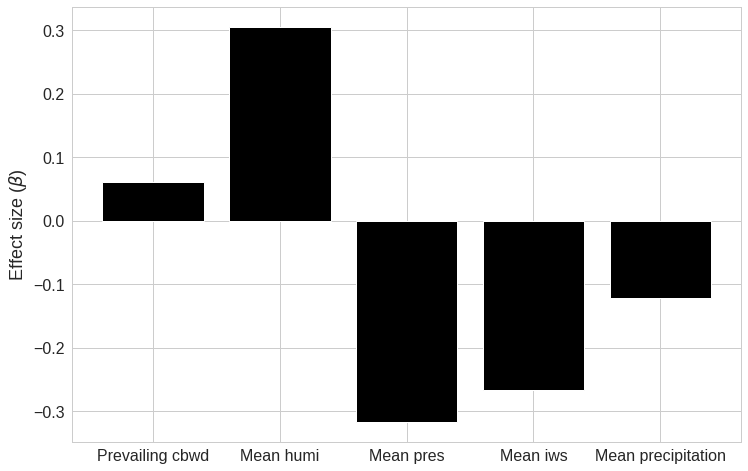

In [604]:
plt.style.use('seaborn-whitegrid')
df_beta = df_summary.loc[[idx for idx in df_summary.index if idx.startswith('beta')]]
fig,ax = plt.subplots(1,1,figsize=(12,8))
meteo_labels = [label.replace('_',' ').capitalize() for label in meteo_vars_to_normalize]
ax.bar(x=np.arange(5),height=df_beta['mean'],data=df_beta,color='black',alpha=1.0,tick_label=meteo_labels)


#ax.set_ylim((-0.2,0.2))
ax.set_ylabel(r'Effect size ($\beta$)',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)

<ErrorbarContainer object of 3 artists>

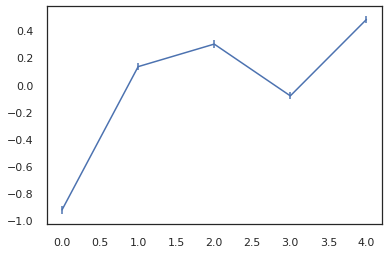

In [545]:
df_eta = df_summary.loc[[idx for idx in df_summary.index if idx.startswith('eta')]]
plt.errorbar(x=np.arange(5),y=df_eta['mean'],yerr=df_eta['sd'])

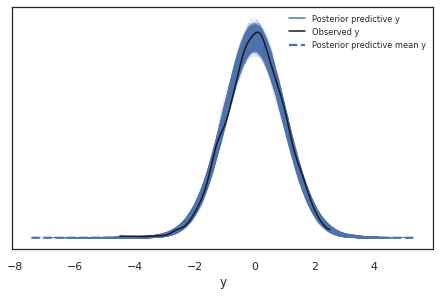

In [484]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=pm25model));

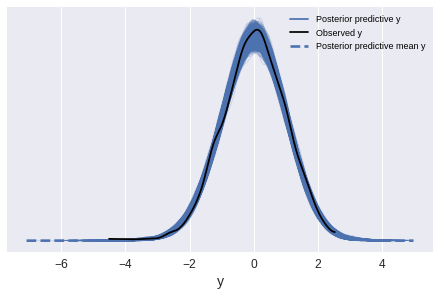

In [308]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=pm25model));

<AxesSubplot:>

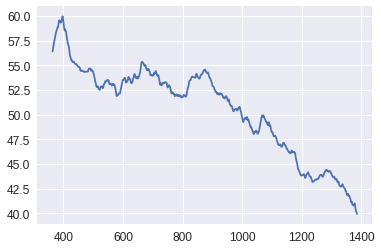

In [324]:
df_agg[df_agg['city_code']==0]['mean_pm'].rolling(365).mean().plot()

In [485]:
df_ppc = pd.DataFrame()

for i in range(5):
    df_ppc[f'rho_{i}'] = ppc['rho'][:,i]
    df_ppc[f'eta_{i}'] = ppc['eta'][:,i]
    
    
for key in ['gamma','delta','epsilon']+['beta_'+str(i) for i in range(5)]:
    df_ppc[key] = ppc[key]

In [486]:
df_ppc.head(5)

rho_0     eta_0     rho_1     eta_1     rho_2     eta_2     rho_3  \
0 -0.055659 -0.939366 -0.162462  0.148057 -0.155963  0.301040 -0.023312   
1 -0.025533 -0.931114 -0.201033  0.150334 -0.043768  0.284689  0.013581   
2 -0.030803 -0.986333 -0.167771  0.129981 -0.109359  0.289284  0.024843   
3 -0.045197 -0.898331 -0.171374  0.177664 -0.055689  0.311394 -0.011129   
4 -0.027761 -0.904371 -0.193788  0.082475 -0.160081  0.312232 -0.012691   

      eta_3     rho_4     eta_4     gamma     delta   epsilon    beta_0  \
0 -0.100822 -0.088554  0.473660  0.233868  0.793903  0.809426  0.057685   
1 -0.067850 -0.101687  0.484879  0.234402  0.857223  0.801514  0.079125   
2 -0.112132 -0.082790  0.473788  0.254010  0.831235  0.806946  0.060035   
3 -0.073283 -0.094824  0.492349  0.232807  0.833875  0.802349  0.078387   
4 -0.078993 -0.087864  0.446537  0.244605  0.782835  0.818261  0.051306   

     beta_1    beta_2    beta_3    beta_4  
0  0.291738 -0.316656 -0.242463 -0.125845  
1  0.305851 -0.334483 -0.282873 -0.120842  
2  0.301316 -0.337379 -0.251647 -0.122039  
3  0.309020 -0.330794 -0.267686 -0.127294  
4  0.287491 -0.295187 -0.275008 -0.118775

In [487]:
def estimate_pm25(params,city,df_agg=df_train_mc,meteo_vars = meteo_vars_to_normalize):
    df_temp = df_agg[df_agg['city'] == city].copy()
    city_code = df_temp['city_code'].values[0]
    omega = (2*np.pi)/365
    trend = params[f'rho_{city_code}'] * df_temp['years_passed'] 
    seasonality = params['gamma']*np.sin(omega*df_temp['days_passed']) + params['delta']*np.cos(omega*df_temp['days_passed'])
    baseline = params[f'eta_{city_code}']
    
    beta_cols = ['beta_'+str(i) for i in range(5)]
    exog = df_temp[meteo_vars].dot(params[beta_cols].values)
    #autoregressive = params['alpha'] * df_temp['sqrt_mean_pm_yesterday']
    log_mean_pm_hat = trend + seasonality + baseline + exog#+ autoregressive #+ random.choice([-1,1]) * params['epsilon']
    #mean_pm_hat = trend + seasonality + baseline + autoregressive
    mean_pm_hat = np.exp(log_mean_pm_hat)
    return trend,seasonality,baseline,exog,log_mean_pm_hat,mean_pm_hat
    

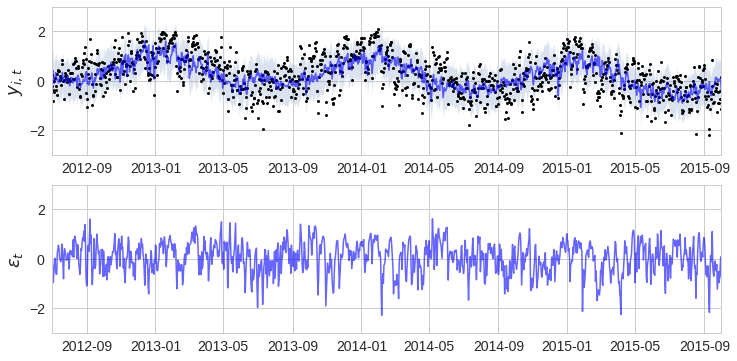

In [635]:
city_code = 1
city = cities[city_code]
df_temp = df_train_mc[df_train_mc['city_code']==city_code]
#sample_params = df_ppc.sample(100)
y_hat = np.zeros((df_temp.shape[0],100))
for i,idx in enumerate(df_ppc.index[:100]):
    sample_params =  df_ppc.loc[idx]
    trend,seasonality,baseline,exog,log_mean_pm_hat,mean_pm_hat = estimate_pm25(sample_params,city)
    #trend,seasonality,baseline,autoregressive,mean_pm_hat = estimate_pm25(sample_params,city)
    y_hat[:,i] = log_mean_pm_hat 
df_y_hat = pd.DataFrame(data=y_hat,index=df_temp['date'])
fig,[ax1,ax2] = plt.subplots(2,1,figsize=(12,6))
ax1.fill_between(df_temp['date'],df_y_hat.mean(axis=1)+df_ppc['epsilon'].mean(),df_y_hat.mean(axis=1)-df_ppc['epsilon'].mean(),alpha=.2)
ax1.plot(df_temp['date'],df_temp['log_mean_pm'],marker='.',linestyle='None',color='black')
ax1.plot(df_y_hat.mean(axis=1),color='blue',alpha=0.6)

ax1.set_xlim(left=pd.to_datetime('2012-7-1'),right=pd.to_datetime('2015-10-01'))
ax1.set_ylim((-3,3))

df_residuals = pd.DataFrame(data=df_temp['log_mean_pm'].values-df_y_hat.mean(axis=1).values,columns=['residuals'],index=df_temp['date'])
ax2.plot(df_residuals,color='blue',alpha=0.6)
ax2.set_xlim(left=pd.to_datetime('2012-7-1'),right=pd.to_datetime('2015-10-01'))
ax2.set_ylim((-3.0,3.0))

ax1.set_ylabel('$y_{i,t}$',fontsize=18)
ax2.set_ylabel('$\epsilon_t$',fontsize=18)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)

(array([ 14.,   6.,   9.,  34., 113., 227., 323., 317., 151.,  21.]),
 array([-2.95967175, -2.50256333, -2.04545492, -1.5883465 , -1.13123808,
        -0.67412966, -0.21702124,  0.24008717,  0.69719559,  1.15430401,
         1.61141243]),
 <BarContainer object of 10 artists>)

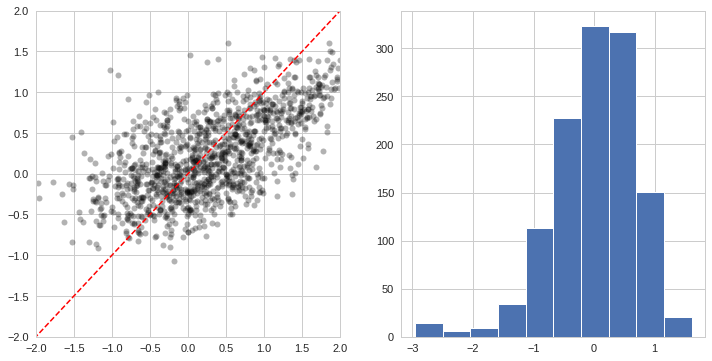

In [636]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(12,6))
ax1.plot(df_temp['log_mean_pm'],df_y_hat.mean(axis=1),marker='o',linestyle='None',alpha=0.3,color='black')
ax1.set_ylim((-2.0,2.0))
ax1.set_xlim((-2.0,2.0))
x_dummy = np.arange(-3,3,0.2)
ax1.plot(x_dummy,x_dummy,linestyle='--',color='red')
ax2.hist(df_residuals)


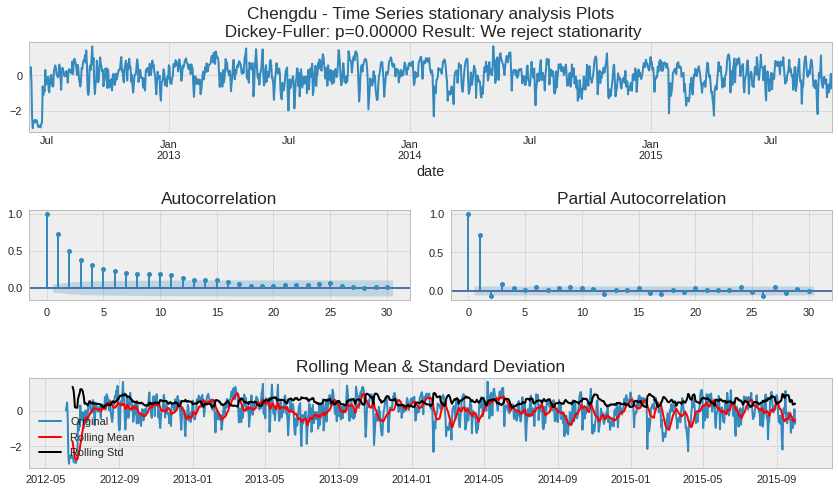

In [622]:
tsplot(df_residuals['residuals'],city,lags=30)

In [644]:
from statsmodels.tsa.ar_model import AutoReg,ar_select_order

res_model = AutoReg(df_residuals['residuals'], lags=15)
res_model_fit = res_model.fit()
print('Coef=%s' % (res_model_fit.params))

Coef=intercept        0.008528
residuals.L1     0.746004
residuals.L2    -0.134103
residuals.L3     0.049742
residuals.L4     0.025228
residuals.L5    -0.030155
residuals.L6     0.034135
residuals.L7    -0.012849
residuals.L8    -0.002074
residuals.L9     0.027615
residuals.L10    0.011588
residuals.L11    0.065236
residuals.L12   -0.058465
residuals.L13    0.013759
residuals.L14   -0.015186
residuals.L15    0.031904
dtype: float64


/home/arashs/anaconda3/envs/MLenv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/arashs/anaconda3/envs/MLenv/lib/python3.6/site-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


In [646]:
df_test_city = df_test_mc[df_test_mc['city_code']==city_code]
df_test_city.index = df_test_city['date']
ar_forecast = res_model_fit.get_prediction(start=df_residuals.index[0],end=df_test_city.index[-1],dynamic=df_residuals.index[-1])
ar_forecast_test = ar_forecast.summary_frame()[df_test_city.index[0]:]
ar_forecast_test

/home/arashs/anaconda3/envs/MLenv/lib/python3.6/site-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,


mean   mean_se  mean_ci_lower  mean_ci_upper
2015-10-02  0.000313  0.459004      -0.899319       0.899944
2015-10-03 -0.026594  0.572657      -1.148980       1.095792
2015-10-04 -0.063328  0.604590      -1.248304       1.121647
2015-10-05 -0.061510  0.616689      -1.270199       1.147178
2015-10-06 -0.102794  0.623706      -1.325235       1.119646
...              ...       ...            ...            ...
2015-12-27  0.034420  0.639620      -1.219212       1.288053
2015-12-28  0.034422  0.639620      -1.219210       1.288055
2015-12-29  0.034424  0.639620      -1.219209       1.288057
2015-12-30  0.034426  0.639620      -1.219207       1.288058
2015-12-31  0.034427  0.639620      -1.219205       1.288060

[91 rows x 4 columns]

In [ ]:
# statsmodels.tsa.arima.model.ARIMA
# res_model = ARIMA(df_residuals['residuals'], order=(10,0,0))
# res_model_fit = res_model.fit(disp=1)
# print(res_model_fit.summary())

#aaa = res_model_fit.get_prediction(start=df_residuals.index[0],end=df_test_city.index[-1],dynamic=df_residuals.index[-30])

In [ ]:
#mean_res_error,std_err,conf_int = res_model_fit.forecast(steps=df_test_city.shape[0])

In [ ]:
# ar_res_model = ar_select_order(df_residuals['residuals'], 30, old_names=False)
# ar_res_model_fit = sel.model.fit()
# print(res.summary())

In [283]:
# ar_forecast= res.get_prediction(start=df_residuals.index[0],end=df_test_city.index[-1],dynamic=df_residuals.index[-1])
# ar_forecast_test = ar_forecast.summary_frame()[df_test_city.index[0]:]

/home/arashs/anaconda3/envs/MLenv/lib/python3.6/site-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,


In [328]:
from sklearn.metrics import mean_squared_error

In [342]:
df_y_hat.mean(axis=1)

date
2012-06-04    0.079094
2012-06-05    0.214096
2012-06-06    0.173098
2012-06-07   -0.018481
2012-06-08    0.121663
                ...   
2015-09-27   -0.118865
2015-09-28   -0.079223
2015-09-29   -0.062929
2015-09-30    0.002204
2015-10-01   -0.426522
Length: 1215, dtype: float64

In [348]:
df_temp['log_mean_pm']

1387    0.303173
1388    0.654959
1389    0.820705
1390   -0.376295
1391   -2.241495
          ...   
2597   -0.913041
2598   -0.736069
2599   -0.406498
2600    0.157068
2601   -1.153768
Name: log_mean_pm, Length: 1215, dtype: float64

In [352]:
df_y_hat ['y_hat_mean'].iloc[15:].values.shape

(1200,)

In [353]:
df_temp['log_mean_pm'].values.shape

(1215,)

In [354]:
mse_train = mean_squared_error(df_temp['log_mean_pm'].iloc[15:].values,df_y_hat ['y_hat_mean'].iloc[15:].values)

In [642]:
df_y_hat['y_hat_mean']

date
2015-10-02   NaN
2015-10-03   NaN
2015-10-04   NaN
2015-10-05   NaN
2015-10-06   NaN
              ..
2015-12-27   NaN
2015-12-28   NaN
2015-12-29   NaN
2015-12-30   NaN
2015-12-31   NaN
Name: y_hat_mean, Length: 91, dtype: float64

In [643]:
ar_forecast_test

mean   mean_se  mean_ci_lower  mean_ci_upper
2019-07-22 -0.001585  0.693765       -1.36134       1.358169
2019-07-23 -0.001585  0.693765       -1.36134       1.358169
2019-07-24 -0.001585  0.693765       -1.36134       1.358169
2019-07-25 -0.001585  0.693765       -1.36134       1.358169
2019-07-26 -0.001585  0.693765       -1.36134       1.358169
...              ...       ...            ...            ...
2019-10-14 -0.001585  0.693765       -1.36134       1.358169
2019-10-15 -0.001585  0.693765       -1.36134       1.358169
2019-10-16 -0.001585  0.693765       -1.36134       1.358169
2019-10-17 -0.001585  0.693765       -1.36134       1.358169
2019-10-18 -0.001585  0.693765       -1.36134       1.358169

[89 rows x 4 columns]

Text(0.5, 1.0, 'Chengdu')

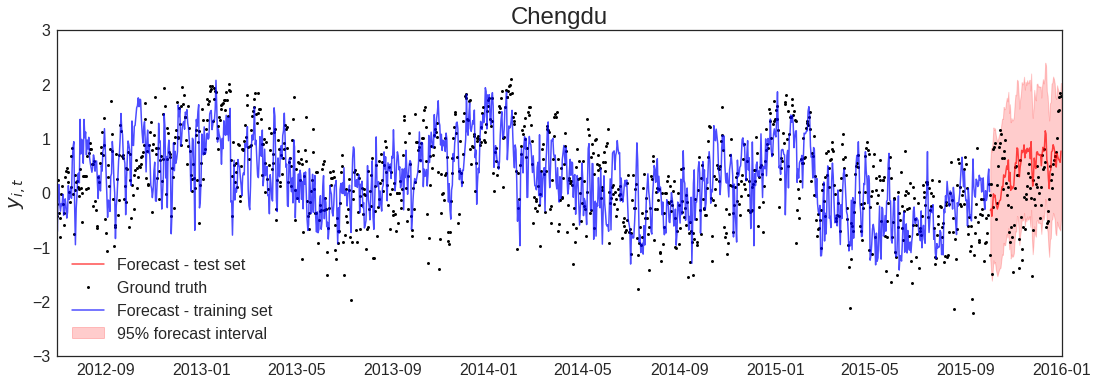

In [659]:
plt.style.use('seaborn-white')
mean_params = df_ppc.mean(axis=0)
df_test_city = df_test_mc[df_test_mc['city_code']==city_code]
df_test_city.index = df_test_city['date']
trend,seasonality,baseline,exog,log_mean_pm_hat,mean_pm_hat = estimate_pm25(mean_params,city,df_agg=df_test_city)
y_hat_test  = log_mean_pm_hat.values

df_y_hat = pd.DataFrame(data=y_hat_test,index=df_test_city['date'],columns=['y_hat_lr'])
df_y_hat['y_hat_mean'] = df_y_hat['y_hat_lr'] + ar_forecast_test['mean'] 
df_y_hat['lower'] = df_y_hat['y_hat_lr'] + ar_forecast_test['mean_ci_lower']
df_y_hat['upper'] = df_y_hat['y_hat_lr'] + ar_forecast_test['mean_ci_upper']
fig,ax1 = plt.subplots(1,1,figsize=(18,6))
#ax1.fill_between(df_test_city['date'],df_y_hat.mean(axis=1)+df_ppc['epsilon'].mean(),df_y_hat.mean(axis=1)-df_ppc['epsilon'].mean(),alpha=.2)
ax1.plot(df_test_city['date'],df_test_city['log_mean_pm'],marker='.',linestyle='None',color='black')
ax1.plot(df_y_hat['y_hat_mean'],color='red',alpha=0.7,label='Forecast - test set')
ax1.fill_between(df_y_hat.index,df_y_hat['lower'],df_y_hat['upper'],color='red',alpha=0.2,label='95% forecast interval')

#mse_test = mean_squared_error(df_test_city['log_mean_pm'],df_y_hat['y_hat_mean'])


df_temp = df_train_mc[df_train_mc['city_code']==city_code]
#sample_params = df_ppc.sample(100)
y_hat = np.zeros((df_temp.shape[0],100))
for i,idx in enumerate(df_ppc.index[:100]):
    sample_params =  df_ppc.loc[idx]
    trend,seasonality,baseline,exog,log_mean_pm_hat,mean_pm_hat = estimate_pm25(sample_params,city)
    #trend,seasonality,baseline,autoregressive,mean_pm_hat = estimate_pm25(sample_params,city)
    y_hat[:,i] = log_mean_pm_hat 
    
    
df_y_hat = pd.DataFrame(data=y_hat,index=df_temp['date'])
df_y_hat ['y_hat_mean'] = df_y_hat.mean(axis=1) + ar_forecast.summary_frame()[:df_y_hat.index[-1]]['mean']

#mse_train = mean_squared_error(df_temp['log_mean_pm'].iloc[15:].values,df_y_hat ['y_hat_mean'].iloc[15:].values)

ax1.plot(df_temp['date'],df_temp['log_mean_pm'],marker='.',linestyle='None',color='black',label='Ground truth')
ax1.plot(df_y_hat.mean(axis=1)+res_hat,color='blue',alpha=0.7,label='Forecast - training set')

ax1.set_ylabel('$y_{i,t}$',fontsize=20)

ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_ylim((-3,3))

ax1.set_xlim(left=pd.to_datetime('2012-7-1'),right=pd.to_datetime('2016-01-01'))

ax1.legend(loc=3,fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax2.tick_params(axis='both', which='major', labelsize=16)

ax1.set_title(city,fontsize=24)

#df_residuals = pd.DataFrame(data=df_temp['log_mean_pm'].values-df_y_hat.mean(axis=1).values,columns=['residuals'],index=df_temp['date'])
#ax2.plot(df_residuals,color='blue',alpha=0.6)